# Interpreting Language Models with Contrastive Explanations
### ___Kayo Yin and Graham Neubig___
This Colab notebook lets you visualize contrastive explanations for language model decisions, based on [Yin and Neubig (2022)](https://arxiv.org/abs/2202.10419).





In [1]:
#@markdown #**Setup Environment**
#@markdown Install and import Python dependencies.
print('Importing libraries...')
from IPython.display import clear_output, Audio
import sys
sys.path.append('./interpret-lm')
from lm_saliency import *
from sklearn.cluster import KMeans
import numpy as np
import random
import hashlib
import re
import sys
import tarfile
from collections import Counter, defaultdict
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import requests
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# import nltk
# from nltk.tokenize import word_tokenize
# nltk.download('all')
sound_file = 'beep.wav'
clear_output()
print('Done!')

if not torch.cuda.is_available():
  print("Please restart runtime with GPU")

Done!


In [209]:
sentence_set = "one_sentence" #ten_sentences, small_sample, full_set, one_sentence
BPE = "normal"
small_vocab = "1_pos"

In [210]:
if not torch.cuda.is_available():
  print("Please restart runtime with GPU")

In [211]:
 #@markdown #**Open pre-made vocab**
  #@markdown Open pre-made vocab made from wikitext-103. The vocab is tokenized and tagged using nltk. It is done beforehand because of memory issues.
with open('/home/scur0635/Baseline_clusters/vocab_tagged.json', 'r') as f:
  vocab_tagged = json.load(f)

In [212]:
#  #@markdown #**Open pre-made sentence list**
#  #@markdown Open pre-made sentence list made from wikitext-103. It is done using regex which is a slow process so done beforehand.
# with open('/home/scur0635/Baseline_clusters/sentences_standard.json', 'r') as f:
#   sentences_list = json.load(f)

In [213]:
# print(vocab_tagged[0])

In [214]:
if sentence_set == "small_sample":
    sentences = ["Can you stop the dog from",
                   "Can you stop the dog",
                   "Can you stop the",
                   "Can you stop",
                   "Can you"]
    
elif sentence_set == "ten_sentences":
    sentences = ["Can you stop the dog from", #barking
                    "Are you sure that he is",    #going
                    "He went with his dad on a trip, they're going", #fishing
                    "There is no point in talking to him, he isn't", #listening
                    "She went to the city with her friends, they're going", #shopping
                    "Don't go out in the sun, it is", #scorching 
                     ""
                    ]
    
elif sentence_set == "full_set":
    with open('/home/scur0635/Baseline_clusters/sentences_standard.json', 'r') as f:
        sentences = json.load(f)
        
elif sentence_set == "one_sentence":
    sentences = ["Can you stop the dog from"]

In [217]:
 #@markdown #**Only take f.i. verbs from the vocab**
i = 5000
if small_vocab == 'split':
    
    verbs = [item for item in vocab_tagged if item[0][1] in ['VBG']]
    sorted_verbs = sorted(verbs, key=lambda x: x[1], reverse=True)    

    nouns = [item for item in vocab_tagged if item[0][1] in ['NN']]
    sorted_nouns = sorted(nouns, key=lambda x: x[1], reverse=True)    

    sorted_words_1 = [x[0] for x in sorted_verbs if not re.findall('[^ a-zA-Z0-9]|unk',x[0][0])]
    sorted_words_2 = [x[0] for x in sorted_nouns if not re.findall('[^ a-zA-Z0-9]|unk',x[0][0])]
    
    sorted_double = sorted_words_1[:i]+sorted_words_2[:i]
    
elif small_vocab == '1_pos':
    
    verbs = [item for item in vocab_tagged if item[0][1] in ['VBG']]
    sorted_verbs = sorted(verbs, key=lambda x: x[1], reverse=True)    
    sorted_double = [x[0] for x in sorted_verbs if not re.findall('[^ a-zA-Z0-9]|unk',x[0][0])]

    
    
    
    
else:
    vocabbaby = [[tagged[0][0], tagged[1]] for tagged in vocab_tagged]

    word_freq_dict = {}

    # Iterate through each item in the vocab list
    for item in vocabbaby:
        word = item[0]
        freq = item[1]

        # If the word is already in the dictionary, add the frequency
        if word in word_freq_dict:
            word_freq_dict[word] += freq
        else:
            # If the word is not in the dictionary, add it with the current frequency
            word_freq_dict[word] = freq

    # Convert the dictionary back to a list of lists
    result_vocab = [[word, freq] for word, freq in word_freq_dict.items()]

    sorted_words = sorted(result_vocab, key=lambda x: x[1], reverse=True)
    sorted_double = [x for x in sorted_words if not re.findall('[^ a-zA-Z0-9]|unk',x[0][0])]
# Print the sorted verbs
top_words = sorted_double[:2*i]
top_words = [x[0] for x in top_words]

In [218]:
if sentence_set == "ten_sentences":
    targets = ["barking", "going", "fishing", "listening", "shopping", "scorching"]
elif sentence_set == "small_sample":
    targets = ["barking", "from", "dog", "the", "stop"]
elif sentence_set == "one_sentence":
    targets = ["barking"]

In [219]:
#  #@markdown #**Sample set X**

if sentence_set == "full_set":
    y_t = "go"
    sample_size = 100 #@param [100, 200, 300, 400, 500]
    target_list = [x for x in sentences_list for trgt in [" "+y_t+" ", " "+y_t+","," "+y_t+"."," "+y_t+"?"," "+y_t+"!"] if trgt in x]
    samples = random.sample(target_list, sample_size)
    samples = [x.split(y_t)[0] for x in samples if re.search(r'.+ .+ '+y_t, x)]

In [220]:
#@markdown #**Load Language Model**
model_name = "gpt-2" #@param ["gpt-2", "gpt-neo"]

if model_name == "gpt-2":
  tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
  model = GPT2LMHeadModel.from_pretrained("gpt2")
  vocab = list(tokenizer.encoder.keys())
elif model_name == "gpt-neo":
  model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
  tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda"
model.to(device)
clear_output()

In [221]:
input = sentences[0].strip() + " "
attention_ids = tokenizer(" fishing")['input_ids']
print(attention_ids)

[12478]


In [222]:
#@markdown #**Retrieve contrastive explanation function**
if BPE == "BPE_on":
    def expl_vec(target, foil, input, explanation):
        
        correct_tokens = tokenizer(" " + target)
        foil_tokens = tokenizer(" " + foil)
        input = input.strip() + " "
        input_ids = tokenizer(input)['input_ids']
        attention_masks = tokenizer(input)['attention_mask']
        
        extra_ids = []
        extra_masks = []
        prediction_list = []
        
        for i, j in zip(foil_tokens['input_ids'],foil_tokens['attention_mask']):
            full_input_ids = input_ids
            full_attention_masks = attention_masks
            for a, b in zip(extra_ids, extra_masks):
                full_input_ids.append(a)
                full_attention_masks.append(b)
            extra_ids.append(i)
            extra_masks.append(j)
            
        if explanation == "erasure":
          contra_explanation = erasure_scores(model, input_tokens, attention_ids, correct=CORRECT_ID, foil=FOIL_ID, normalize=True)
        else:
          saliency_matrix, embd_matrix = saliency(model, input_tokens, attention_ids, foil=FOIL_ID)
          if explanation == "input x gradient":
            contra_explanation = input_x_gradient(saliency_matrix, embd_matrix, normalize=True)
          elif explanation == "gradient norm":
            contra_explanation = l1_grad_norm(saliency_matrix, normalize=True)






elif BPE == "normal":
    def expl_vec(target, foil, input, explanation):

      input = input.strip() + " "
      input_tokens = tokenizer(input)['input_ids']
      attention_ids = tokenizer(input)['attention_mask']
      CORRECT_ID = tokenizer(" "+ target)['input_ids'][0]
      FOIL_ID = tokenizer(" "+ foil)['input_ids'][0]


      if explanation == "erasure":
        contra_explanation = erasure_scores(model, input_tokens, attention_ids, correct=CORRECT_ID, foil=FOIL_ID, normalize=True)
      else:
        saliency_matrix, embd_matrix = saliency(model, input_tokens, attention_ids, foil=FOIL_ID, correct = CORRECT_ID)
        if explanation == "input x gradient":
          contra_explanation = input_x_gradient(saliency_matrix, embd_matrix, normalize=True)
        elif explanation == "gradient norm":
          contra_explanation = l1_grad_norm(saliency_matrix, normalize=True)
      return contra_explanation

elif BPE == "discard":
    def expl_vec(target, foil, input, explanation):

      input = input.strip() + " "
      input_tokens = tokenizer(input)['input_ids']
      attention_ids = tokenizer(input)['attention_mask']
      CORRECT_ID = tokenizer(" "+ target)['input_ids'][0]
      FOIL_ID = tokenizer(" "+ foil)['input_ids'][0]


      if explanation == "erasure":
        contra_explanation = erasure_scores(model, input_tokens, attention_ids, correct=CORRECT_ID, foil=FOIL_ID, normalize=True)
      else:
        saliency_matrix, embd_matrix = saliency(model, input_tokens, attention_ids, foil=FOIL_ID)
        if explanation == "input x gradient":
          contra_explanation = input_x_gradient(saliency_matrix, embd_matrix, normalize=True)
        elif explanation == "gradient norm":
          contra_explanation = l1_grad_norm(saliency_matrix, normalize=True)
      return contra_explanation

In [223]:
if sentence_set in ["small_sample", "one_sentence"]:
    result_list = []
    for i, target in enumerate(targets):
        temp_list = []
        for foil in top_words:
            e_y_t = expl_vec(target, foil, sentences[i], "input x gradient")
            temp_list.append(e_y_t)
        result_list.append(temp_list)

elif sentence_set == "full_set":
    results = []
    for target in targets:
      for foil in top_words:
        vec_list = []
        for input in sentences:
          e_x_y_t = expl_vec(target, foil, input, "input x gradient")
          vec_list.append(e_x_y_t)
        e_y_t = np.concatenate(vec_list)
        results.append(e_y_t)

elif sentence_set == "ten_sentences":
    results = []
    for foil in top_words:
        vec_list = []
        for input,target in zip(sentences, targets):
          e_x_y_t = expl_vec(target, foil, input, "input x gradient")
          vec_list.append(e_x_y_t)
        e_y_t = np.concatenate(vec_list)
        results.append(e_y_t)

In [224]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


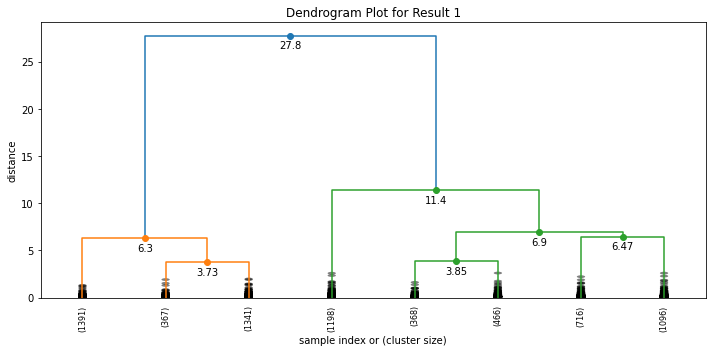

In [225]:
all_linkage_matrices = []    
for i, result in enumerate(result_list):
    X = np.array(result)
    linkage_matrix = linkage(X, 'ward')
    all_linkage_matrices.append(linkage_matrix)
    plt.figure(figsize=(10, 5))
    fancy_dendrogram(
        linkage_matrix,
        truncate_mode='lastp',
        p=8,
        leaf_rotation=90.,
        leaf_font_size=8.,
        show_contracted=True,
        annotate_above=1,  # useful in small plots so annotations don't overlap
    )
    plt.title(f'Dendrogram Plot for Result {1+i}')
    plt.tight_layout()
    plt.savefig(f'Dendrogram_Result_Normalized+fix_{1+i}.png', dpi = 300)
    plt.show()

In [226]:
def map_words_to_clusters(words, indices):
    word_clusters = {}

    for word, cluster_index in zip(words, indices):
        if cluster_index not in word_clusters:
            word_clusters[cluster_index] = [word]
        else:
            word_clusters[cluster_index].append(word)

    return word_clusters

In [227]:
def take_mean_vec(top_words, results, cluster_index,clusters_words):
    listie = []
    for i in zip(top_words, results):
        if i[0] in clusters_words[cluster_index]:
            listie.append(np.array(i[1]))
    mean_vectors = np.mean(listie, axis=0)
    return mean_vectors

Cluster 1: Cluster length 3099 :['being', 'including', 'following', 'according', 'having', 'using', 'making', 'writing', 'working', 'leading'].....['twelfth', 'konditioning', 'richie', 'enter', 'xijing', 'belling', 'unzipping', 'type', 'adorn', 'metaprogramming']

Cluster 2: Cluster length 1198 :['king', 'allowing', 'resulting', 'featuring', 'returning', 'reaching', 'causing', 'scoring', 'serving', 'surrounding'].....['rawling', 'tourcoing', 'magic', 'jack', 'footring', 'casimir', 'mouthbrooding', 'patrick', 'galilee', 'preconditioning']

Cluster 3: Cluster length 2646 :['stating', 'filming', 'noting', 'forming', 'arriving', 'consisting', 'citing', 'forcing', 'defeating', 'completing'].....['athanasius', 'eccleston', 'taller', 'ailbhe', 'tonguing', 'rainbow', 'commonplace', 'dots', 'videoconferencing', 'metro']



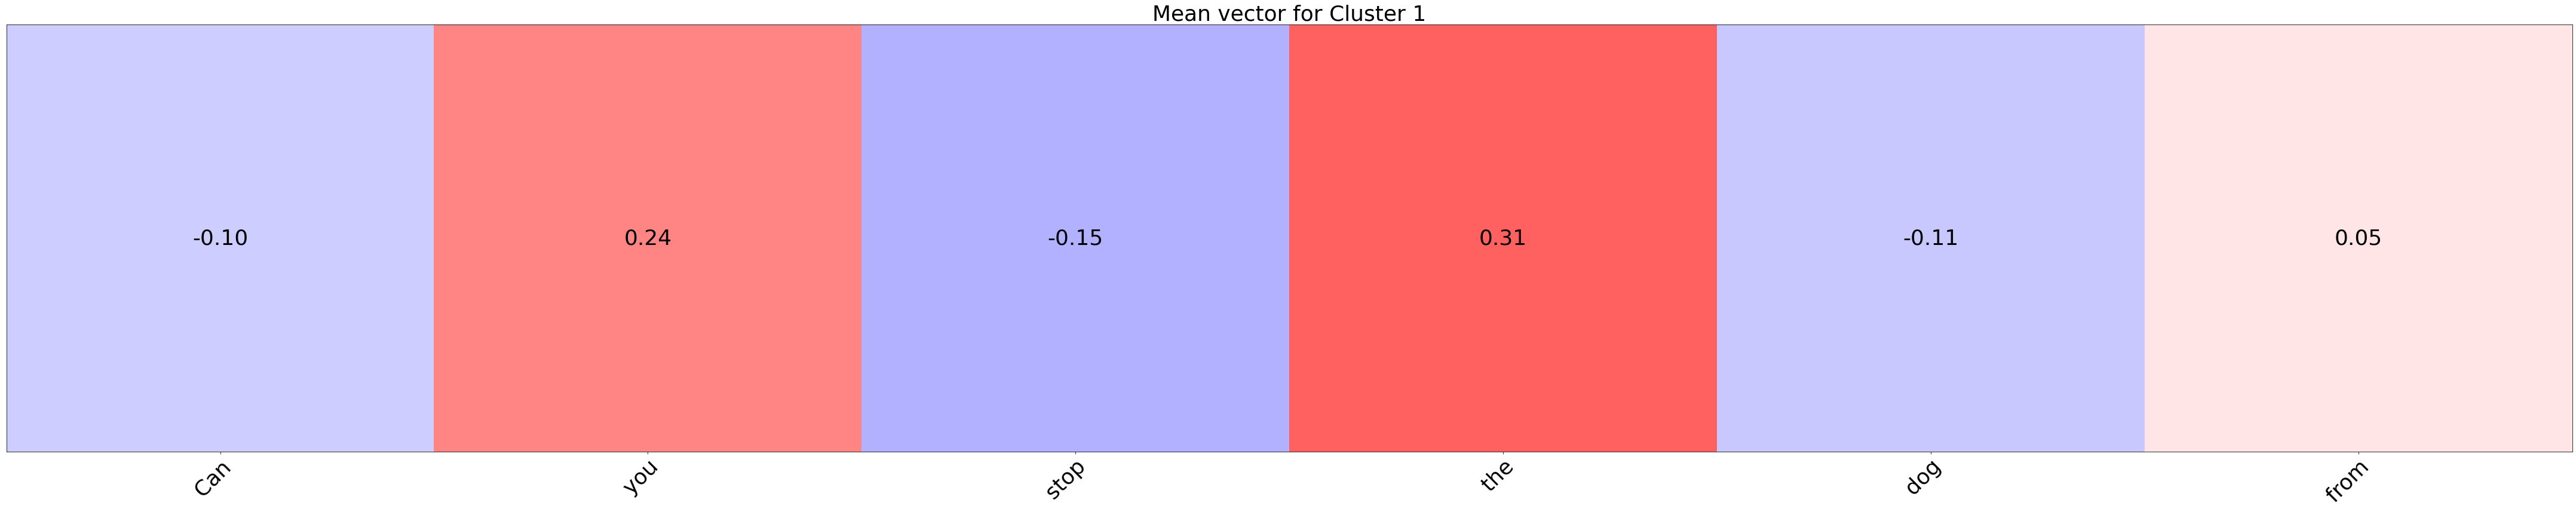

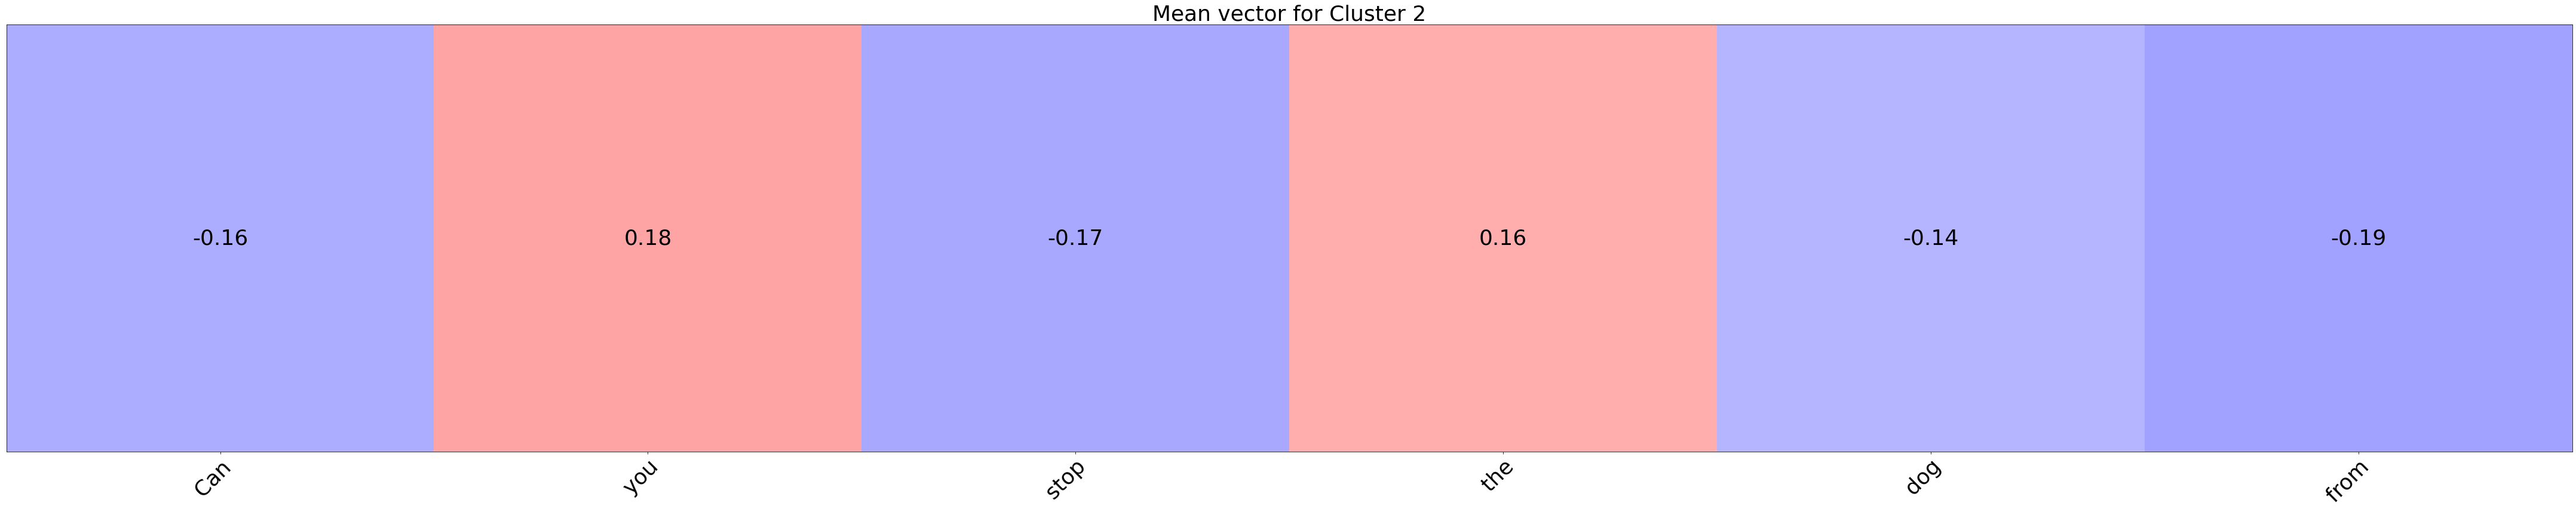

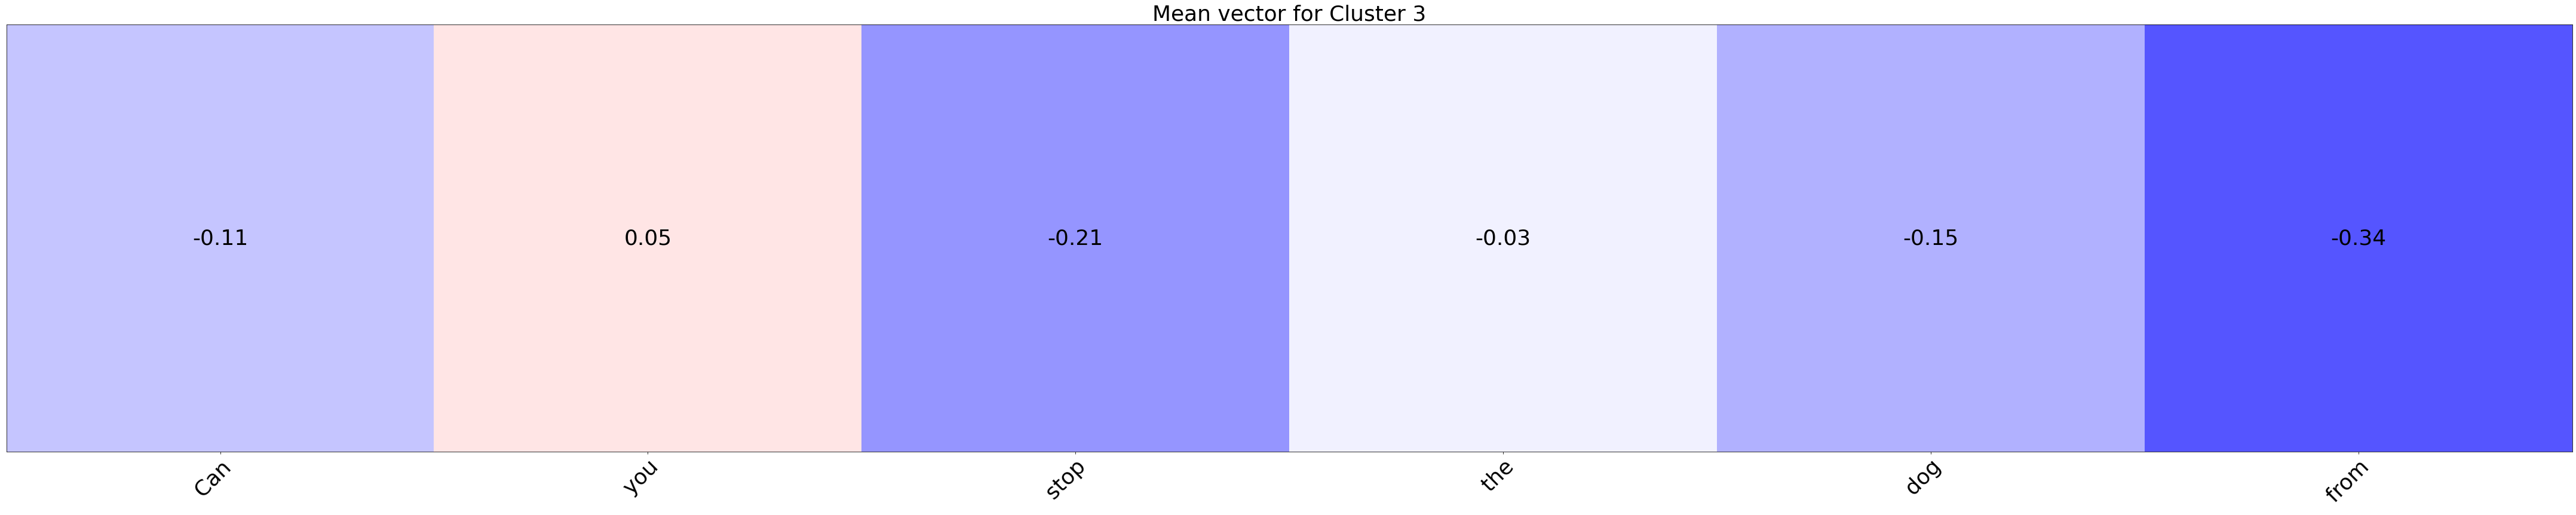

In [233]:
if sentence_set == "ten_sentences":
    clusters = fcluster(linkage_matrix, t = 26.6, criterion= 'distance')
    clusters_words = dict(sorted(map_words_to_clusters(top_words, clusters).items()))
    for cluster_index, cluster_words in clusters_words.items():
            print(f"Cluster {cluster_index}: Cluster length {len(cluster_words)} :{cluster_words[:10]}")
    cluster_means = [take_mean_vec(top_words, results, x,clusters_words) for x in clusters_words.keys()]
    num_clusters = len(cluster_means)
    subvector_lengths = [len(tokenizer(x)['input_ids']) for x in sentences]
    split_cluster_means = [
        [
            item[sum(subvector_lengths[:i]): sum(subvector_lengths[:i + 1])]
            for i in range(len(subvector_lengths))
        ]
        for item in cluster_means
    ]
    for clustermean in split_cluster_means:
        for i,sentencey in enumerate(sentences):
                visualize(clustermean[i], tokenizer,[tokenizer(sentencey)['input_ids']], print_text=True, title=f"Mean vector for Sentence {i+1}")
    

else:
    def visualize_clusters(top_words, sample,  result, linkage_matrix, theta, criterion_var = 'distance'):

        clusters = fcluster(linkage_matrix, t = theta, criterion= criterion_var)
    #     clusters = DBSCAN(eps=.25, min_samples=150).fit(linkage_matrix).labels_

        clusters_words = dict(sorted(map_words_to_clusters(top_words, clusters).items()))

        for cluster_index, cluster_words in clusters_words.items():
            print(f"Cluster {cluster_index}: Cluster length {len(cluster_words)} :{cluster_words[:10]}.....{cluster_words[-10:]}\n")

        cluster_means = [take_mean_vec(top_words, result, x,clusters_words) for x in clusters_words.keys()]
        num_clusters = len(cluster_means)

        for i in range(num_clusters):
#         for i in [2,0,1]:
            visualize(cluster_means[i], tokenizer,[tokenizer(sample)['input_ids']], print_text=True, title=f"Mean vector for Cluster {i+1}")
    
#---------------------------------------------------------------------------------------    
    i = 0
    visualize_clusters(top_words, sentences[i],result_list[i],linkage_matrix, 11 )

In [229]:
Audio(sound_file, autoplay=True)

In [230]:
# for i in ['stating', 'filming', 'noting', 'forming', 'arriving', 'consisting', 'citing', 'forcing', 'defeating', 'completing', 'believing', 'earning', 'establishing', 'indicating', 'destroying', 'praising', 'extending', 'preparing', 'hoping', 'commenting', 'advancing', 'flooding', 'owing', 'ranking', 'capturing', 'qualifying', 'occurring', 'depicting', 'releasing', 'measuring']:
#     print(tokenizer(" "+i)["input_ids"])

Cluster 1: Cluster length 7 :['ian', 'ernest', 'ivan', 'ix', 'vernon', 'iphone', 'ernst']
Cluster 2: Cluster length 1340 :['first', 'been', 'during', 'i', 'game', 'later', 'between', 'than', 'film', 'may']
Cluster 3: Cluster length 1019 :['the', 'of', 'and', 'in', 'to', 'a', 'was', 'on', 'as', 'for']
Cluster 4: Cluster length 1376 :['album', 'american', 'km', 'april', 'french', 'english', 'tour', 'hurricane', 'america', 'mm']
Cluster 5: Cluster length 1799 :['000', 'august', 'january', 'songs', 'ii', 'highway', 'australia', 'ft', 'australian', 'david']
Cluster 6: Cluster length 1492 :['season', 'north', 'state', 'south', 'music', 'episode', 'states', 'began', 'released', 'west']
Cluster 7: Cluster length 217 :['march', 'attempt', 'join', 'serve', 'capture', 'begin', 'develop', 'perform', 'receive', 'launch']
Cluster 8: Cluster length 2750 :['song', 'united', 'century', 'john', 'band', 'wrote', 'river', 'league', 'route', 'species']


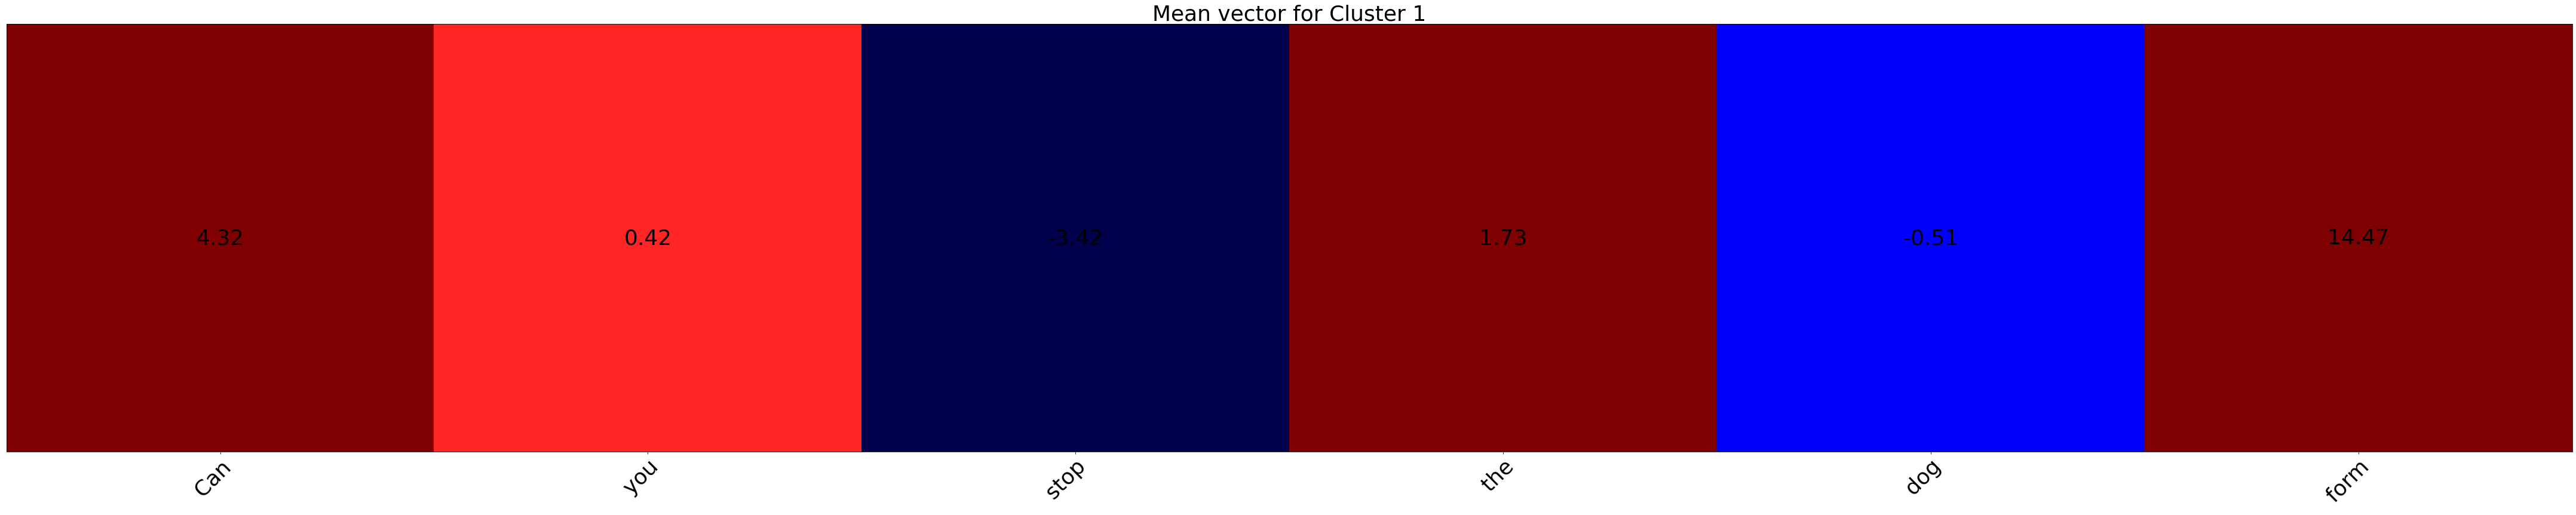

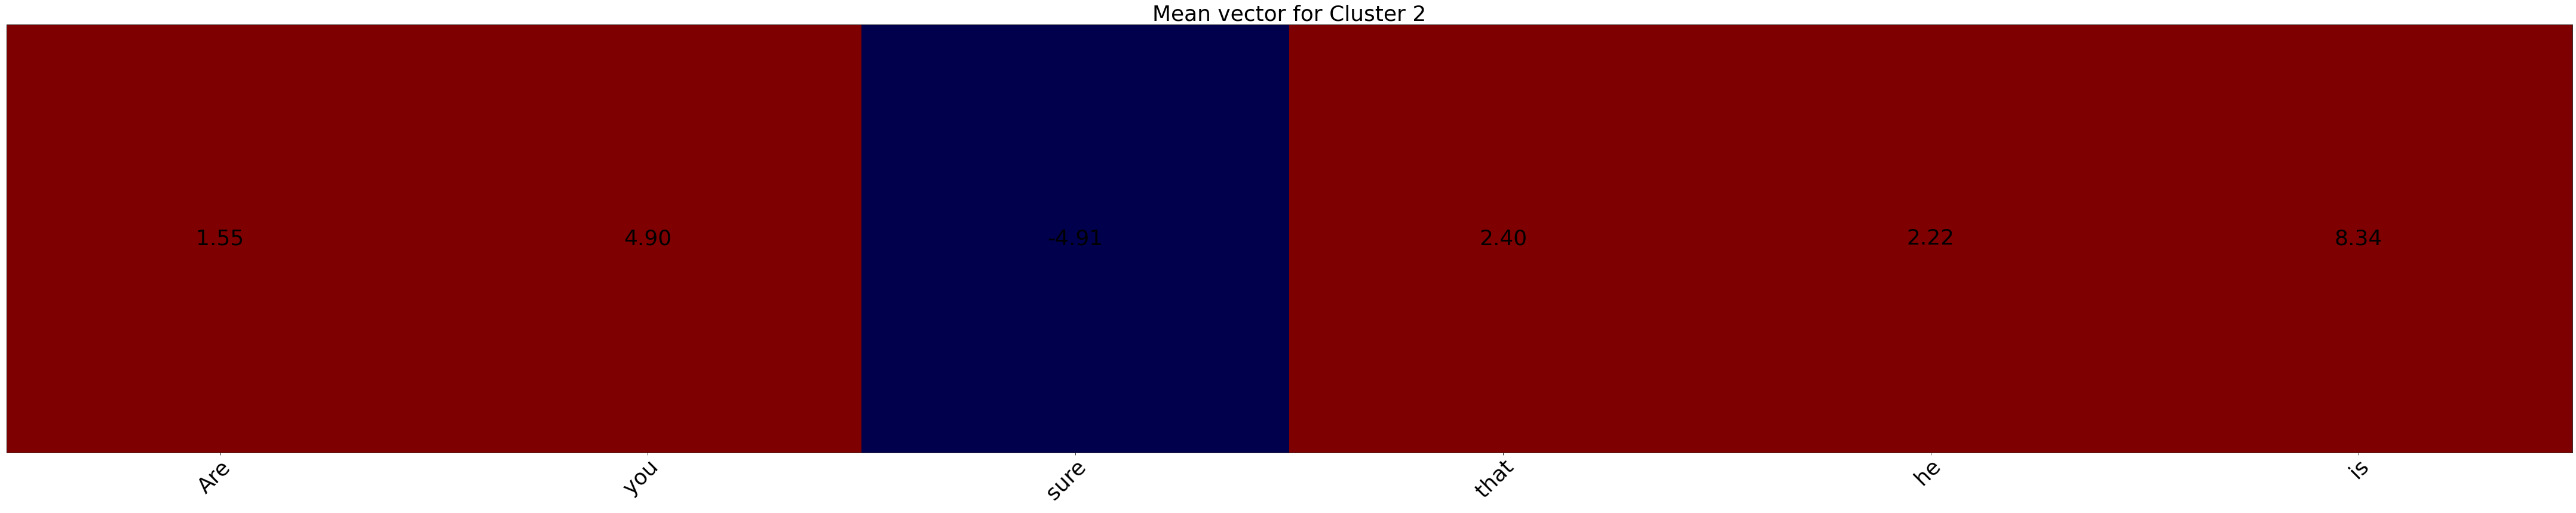

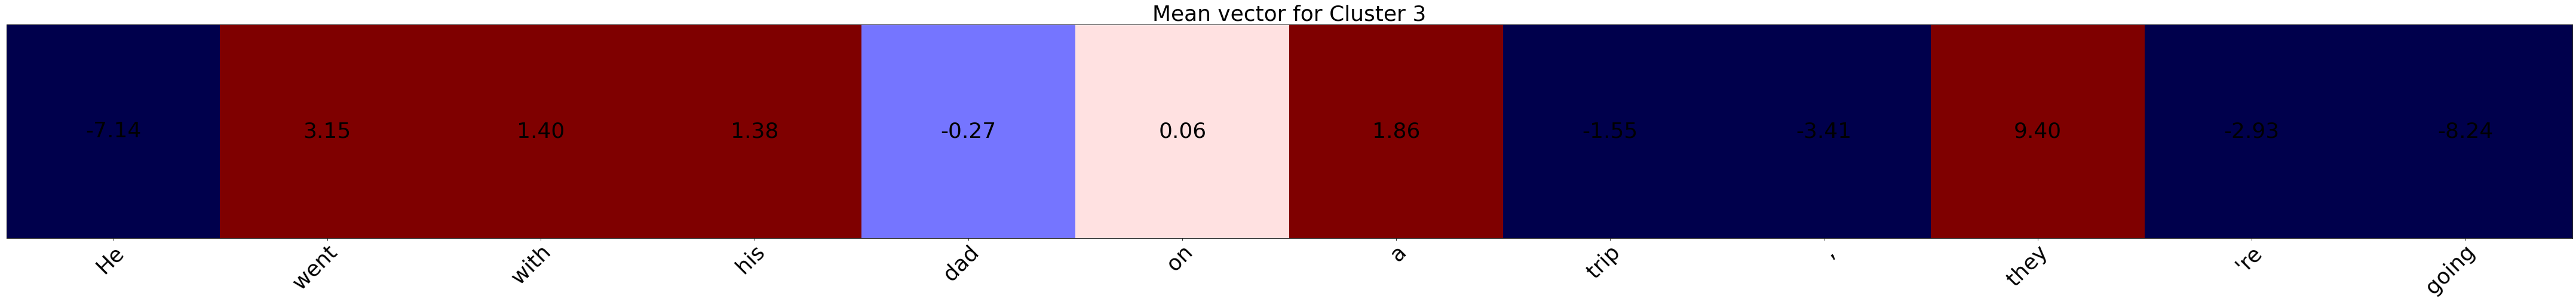

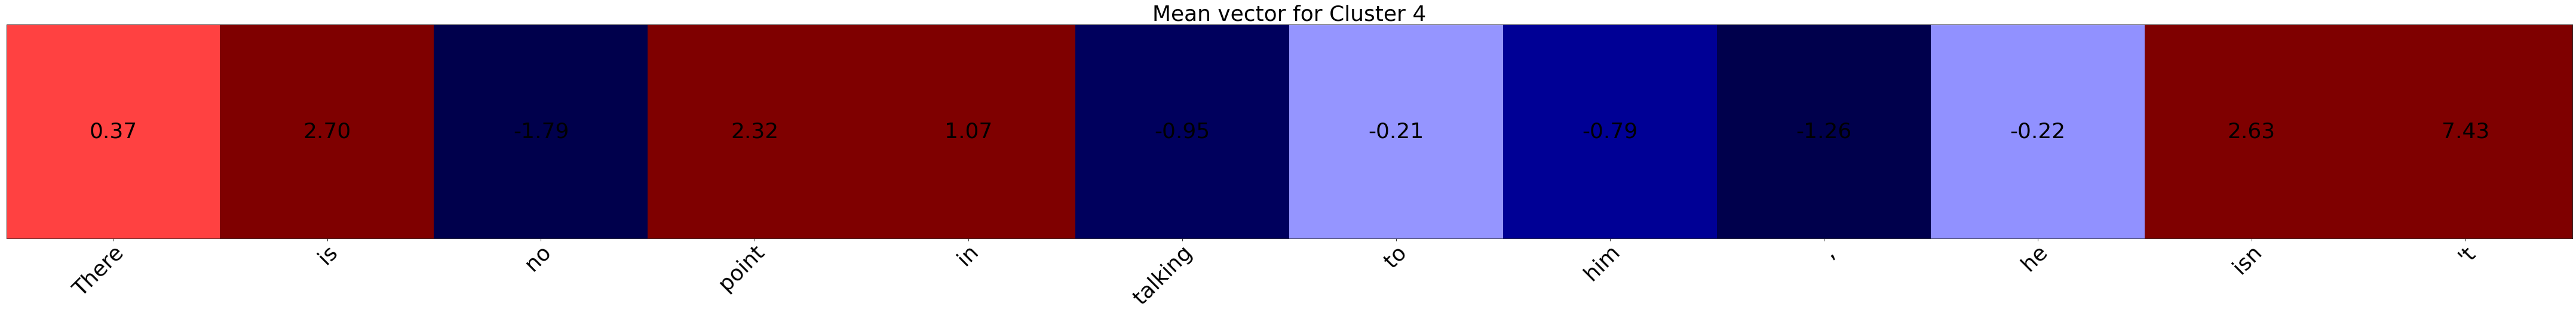

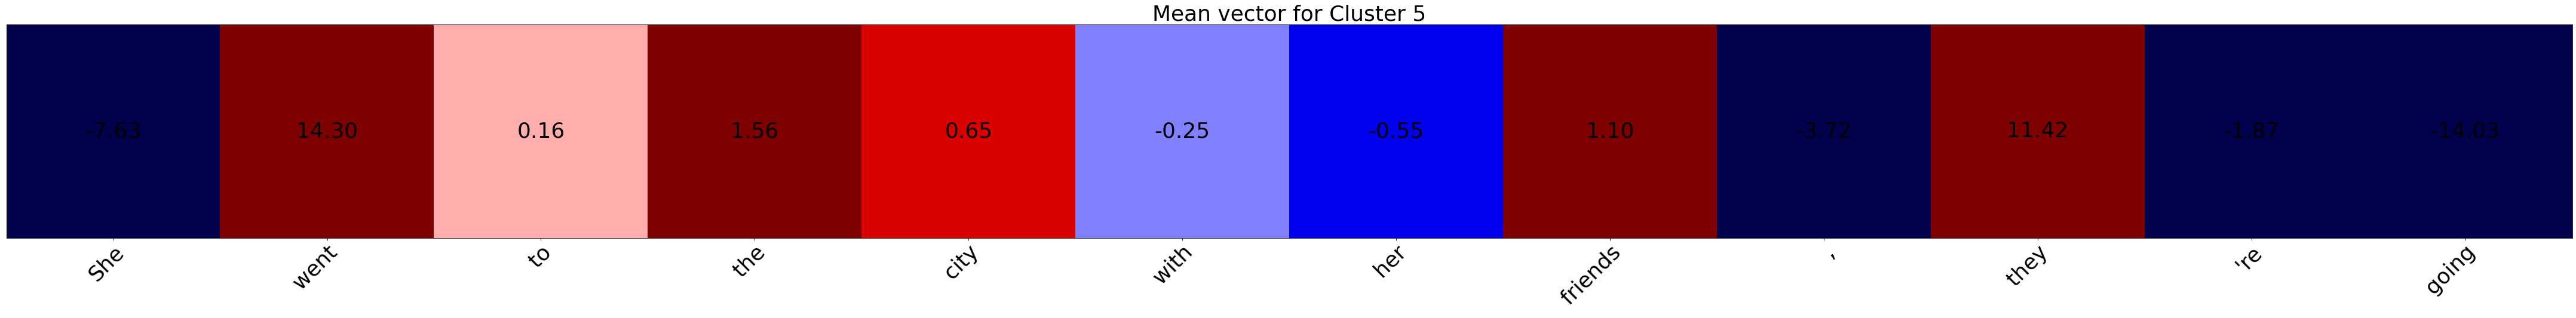

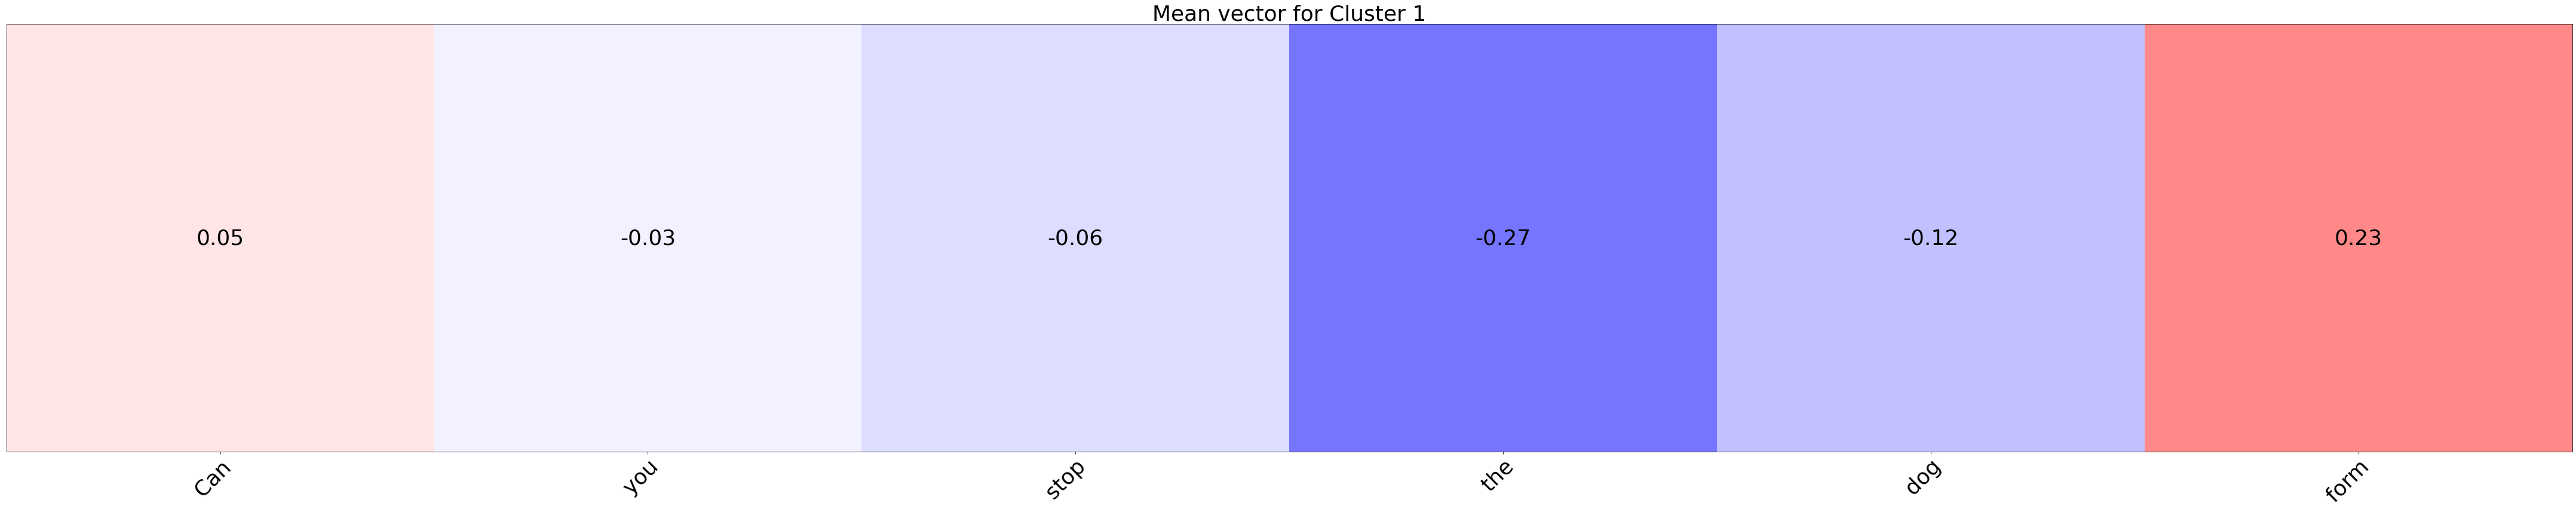

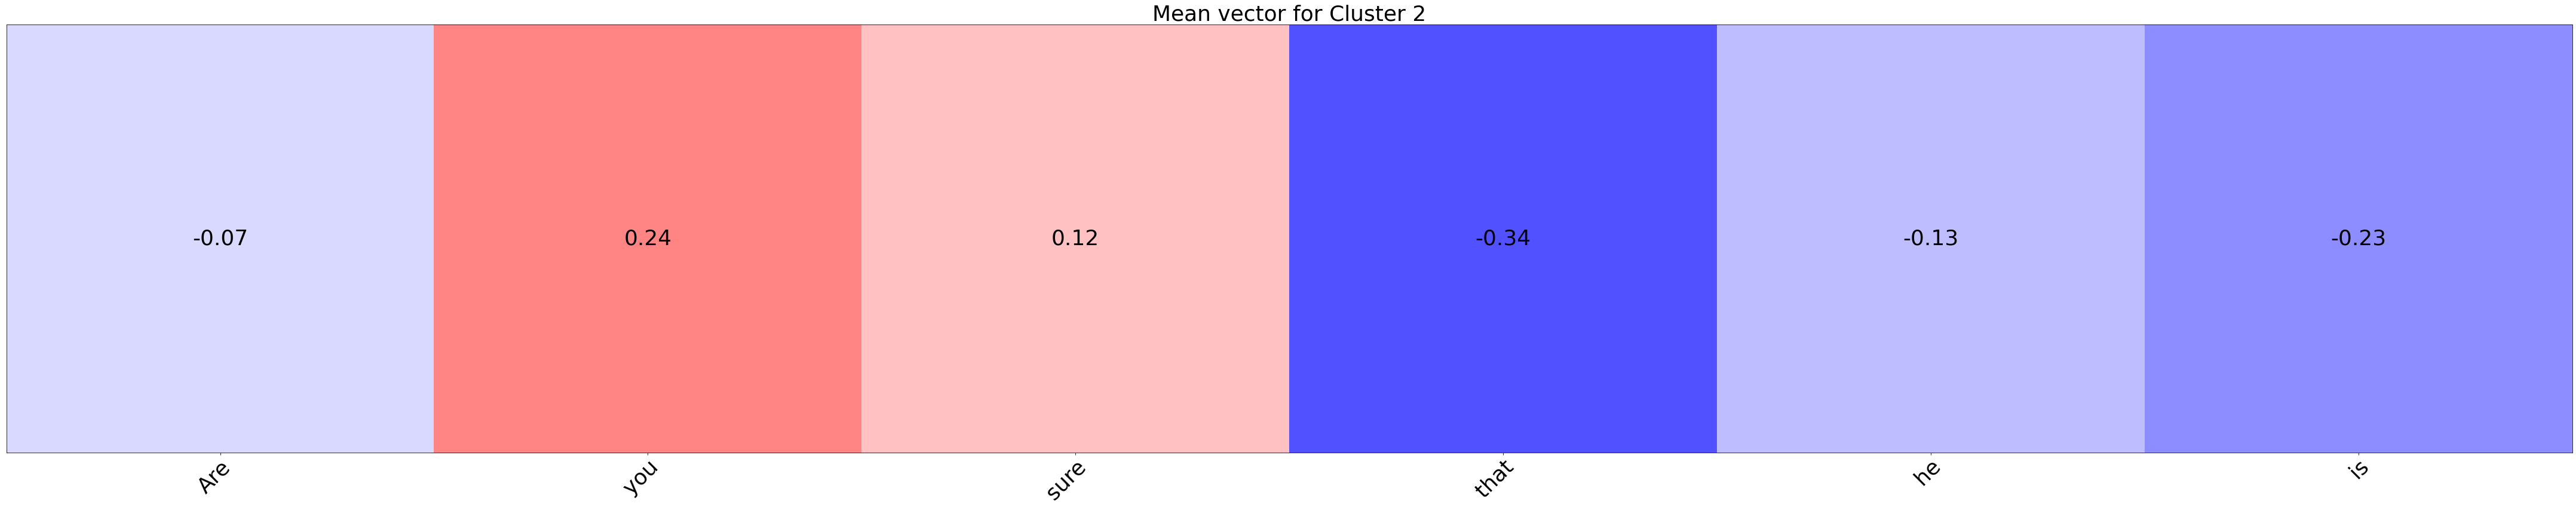

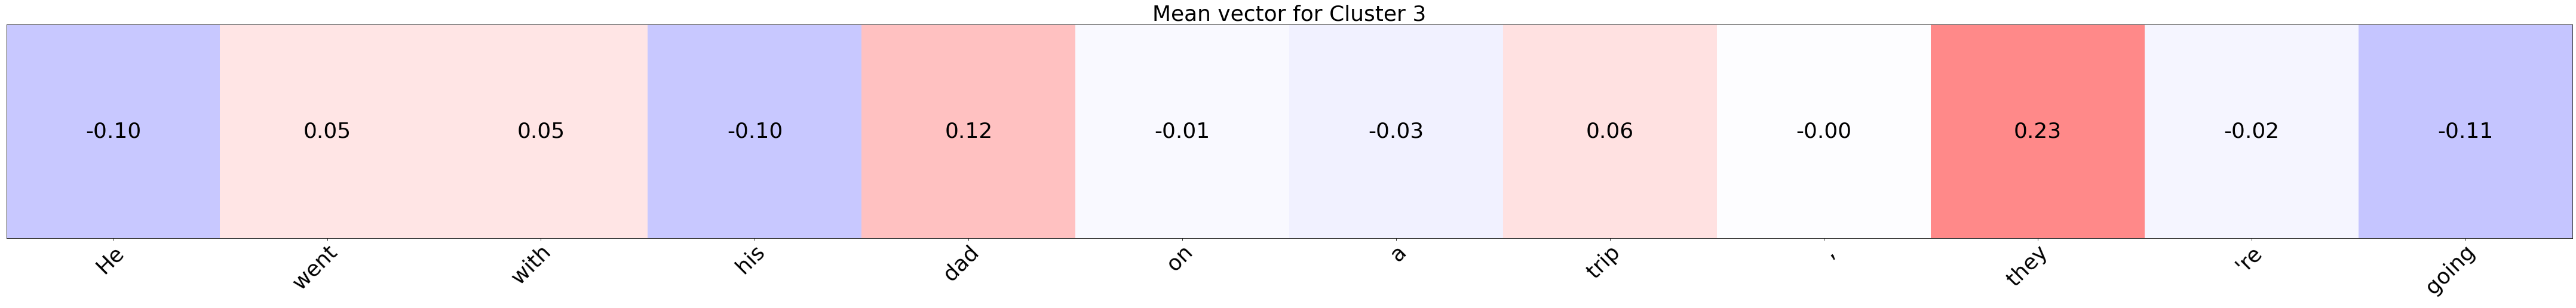

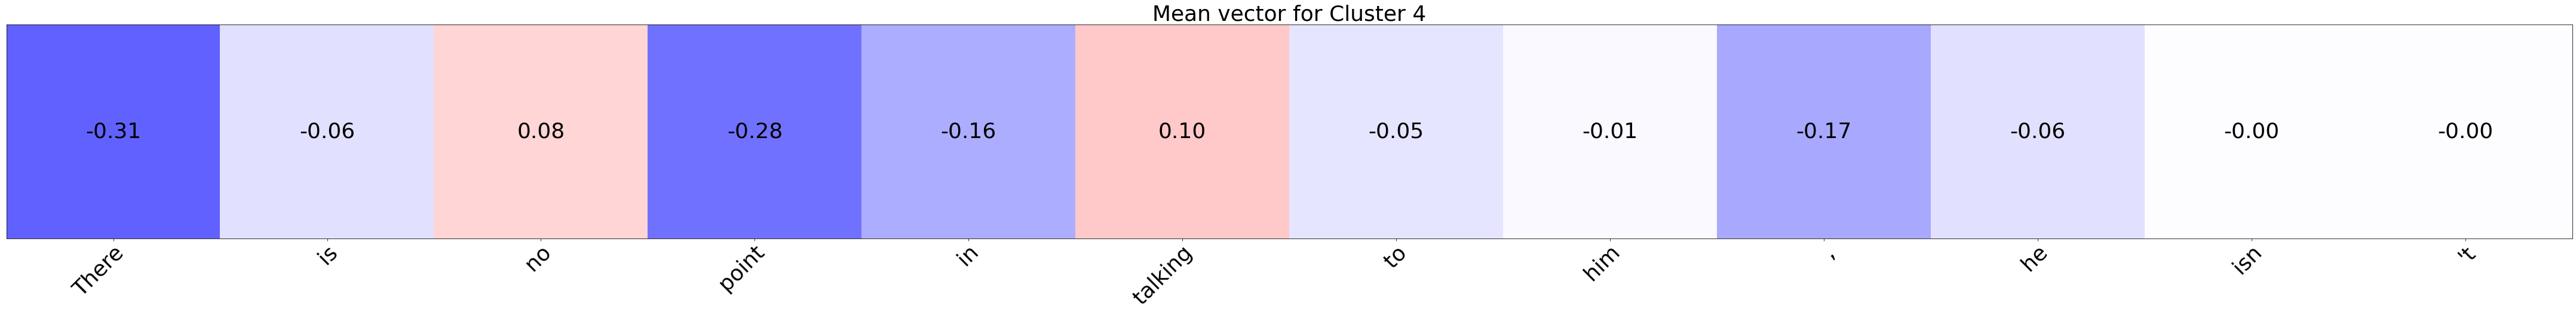

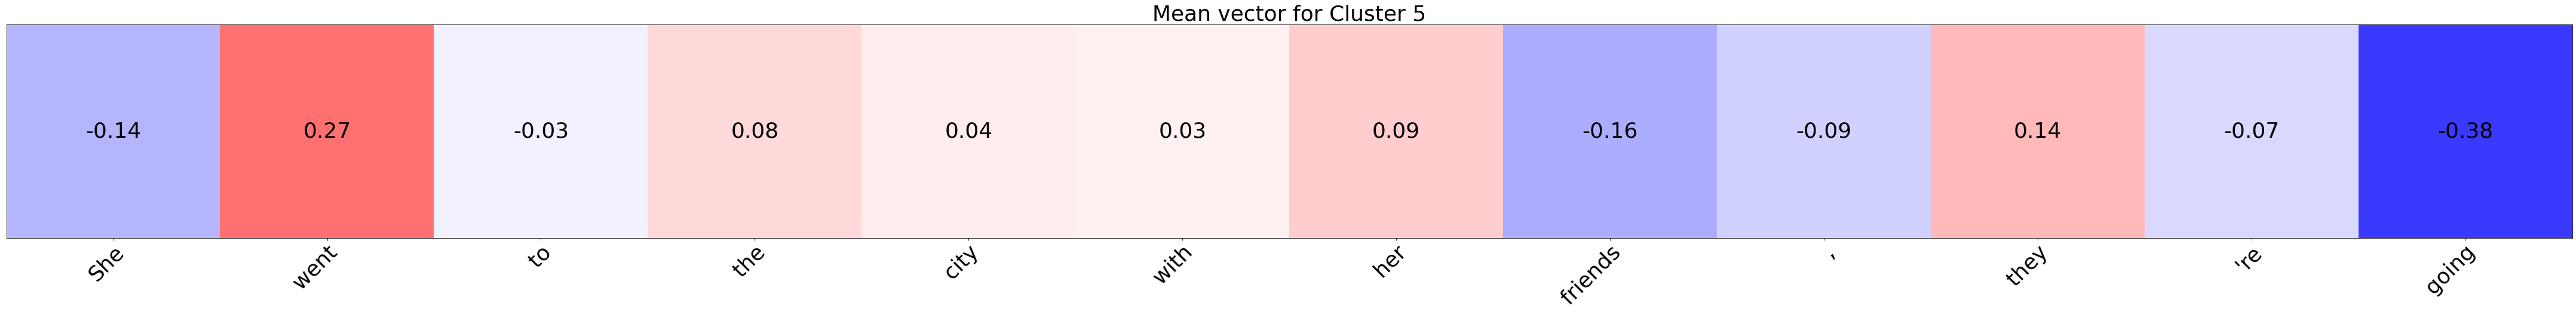

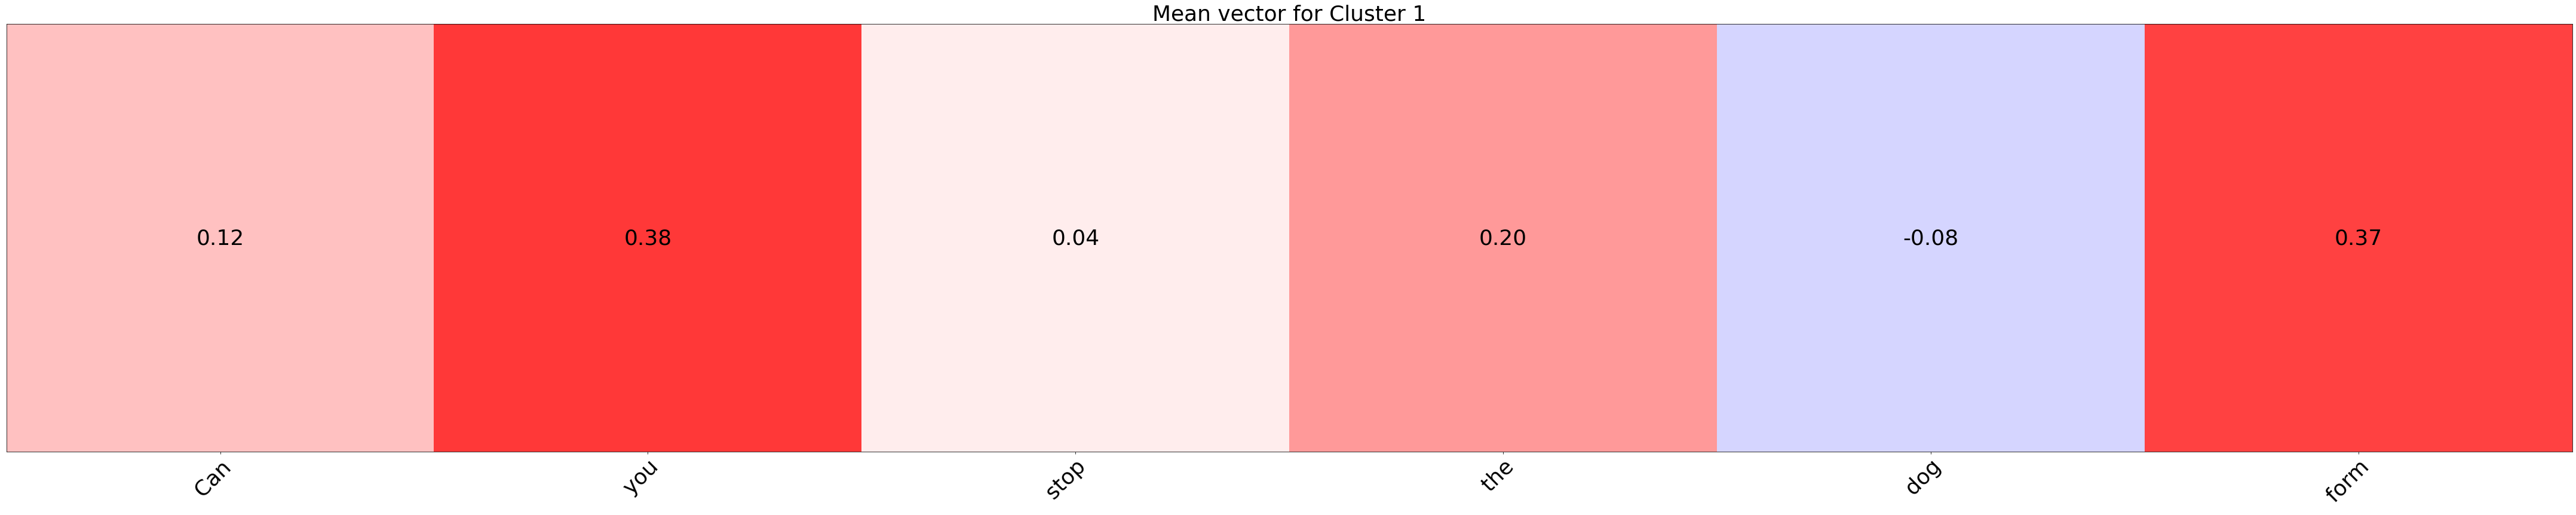

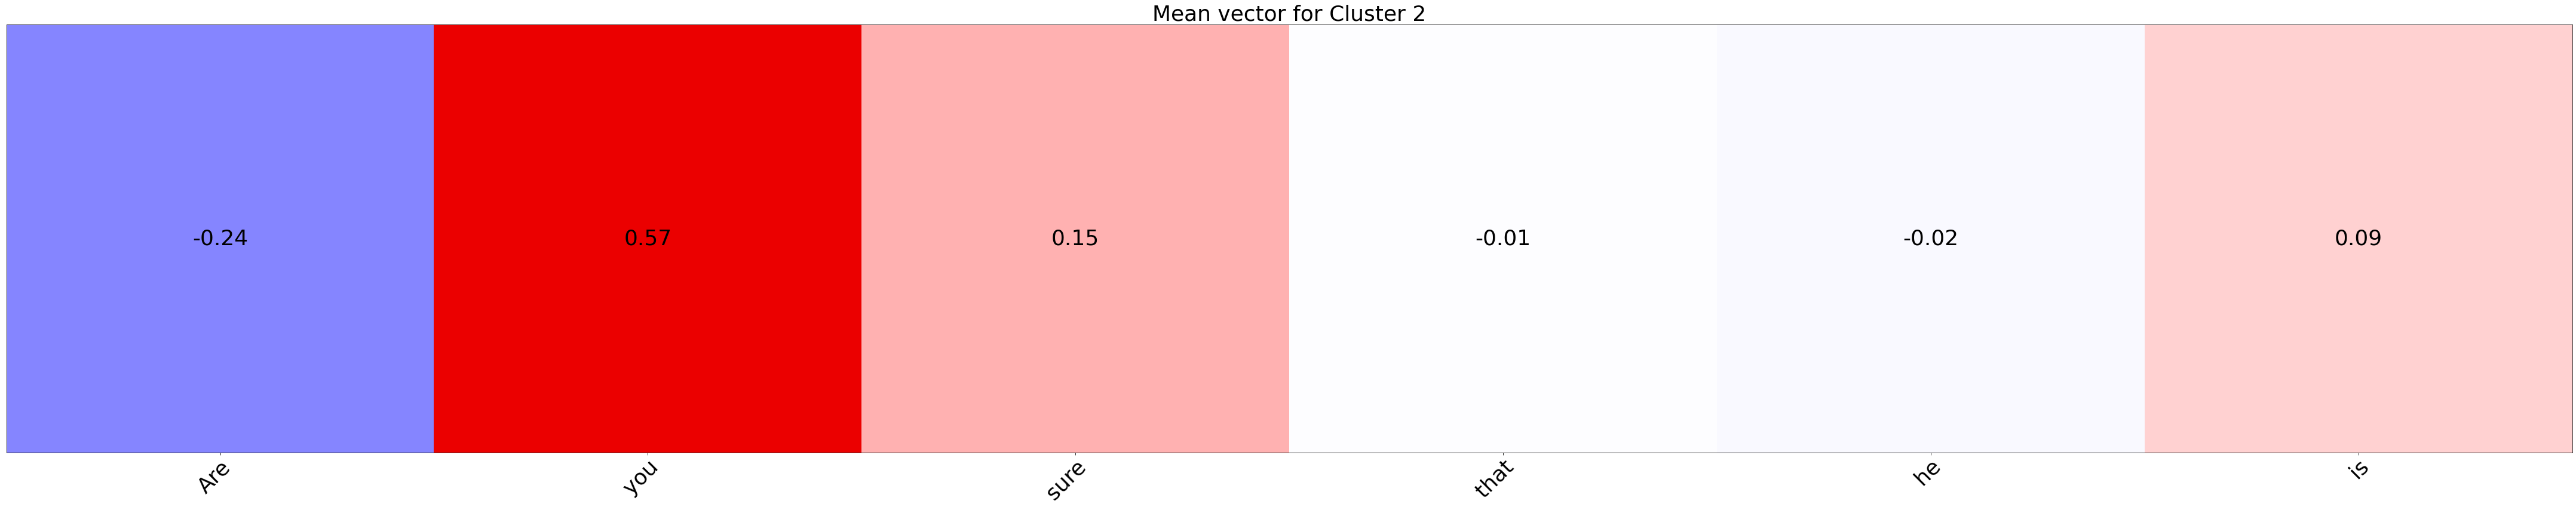

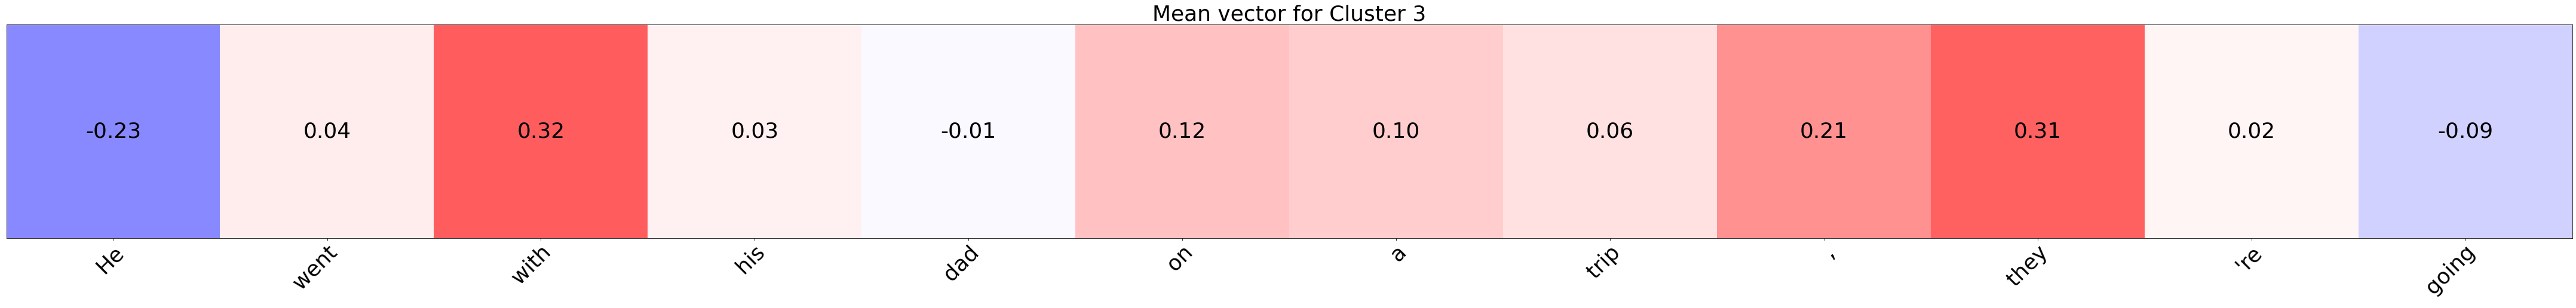

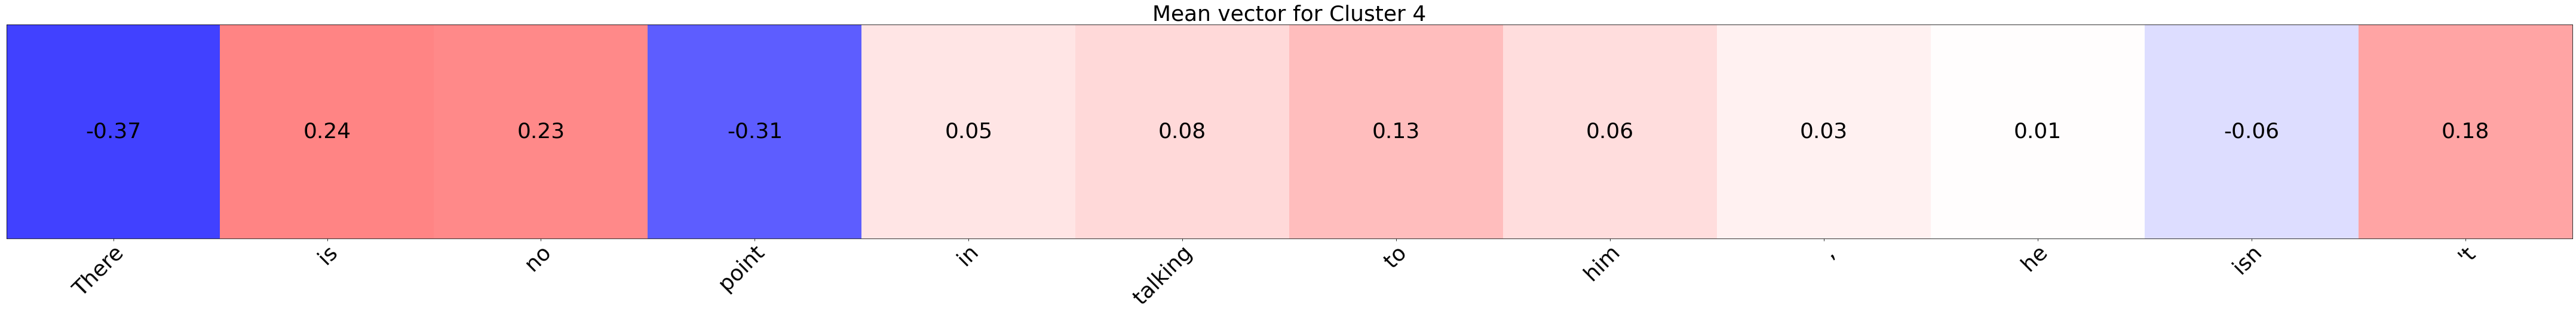

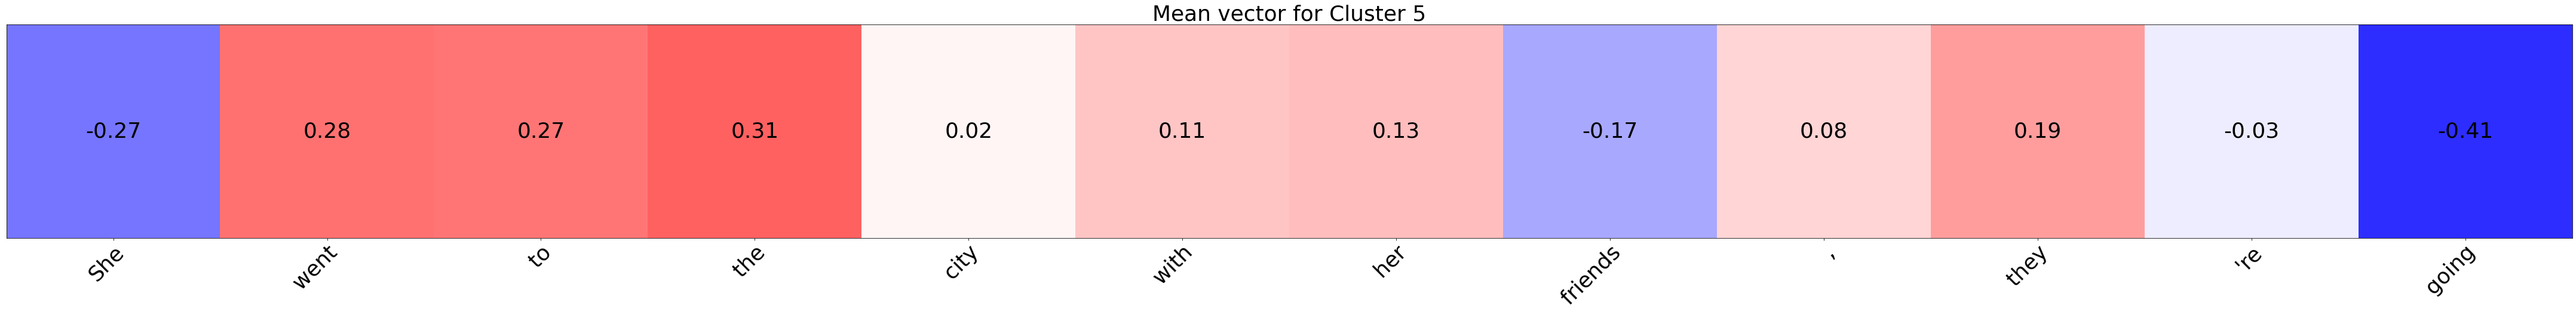

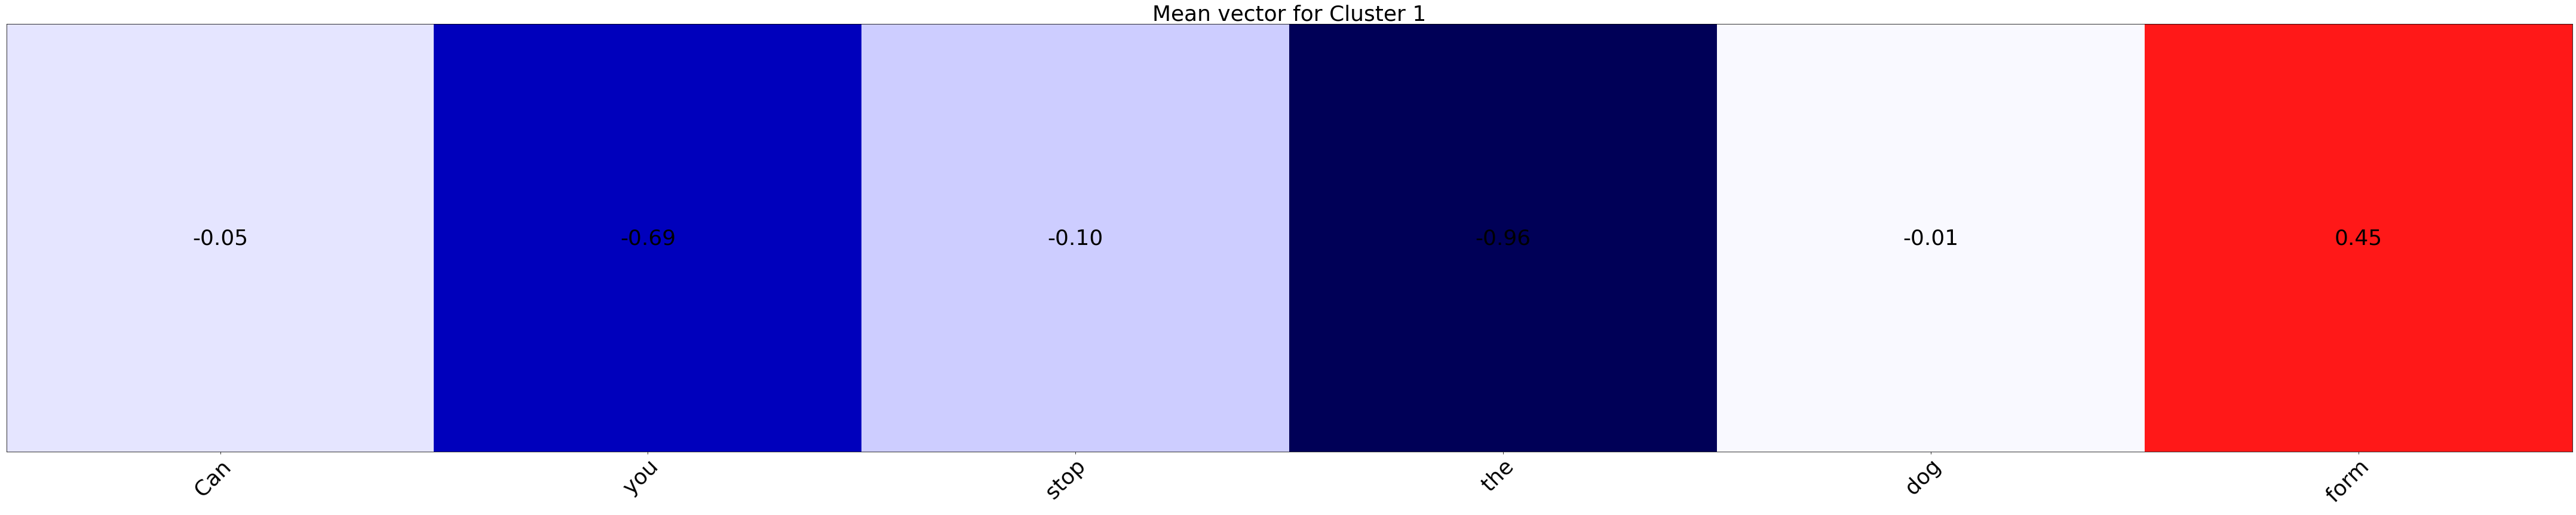

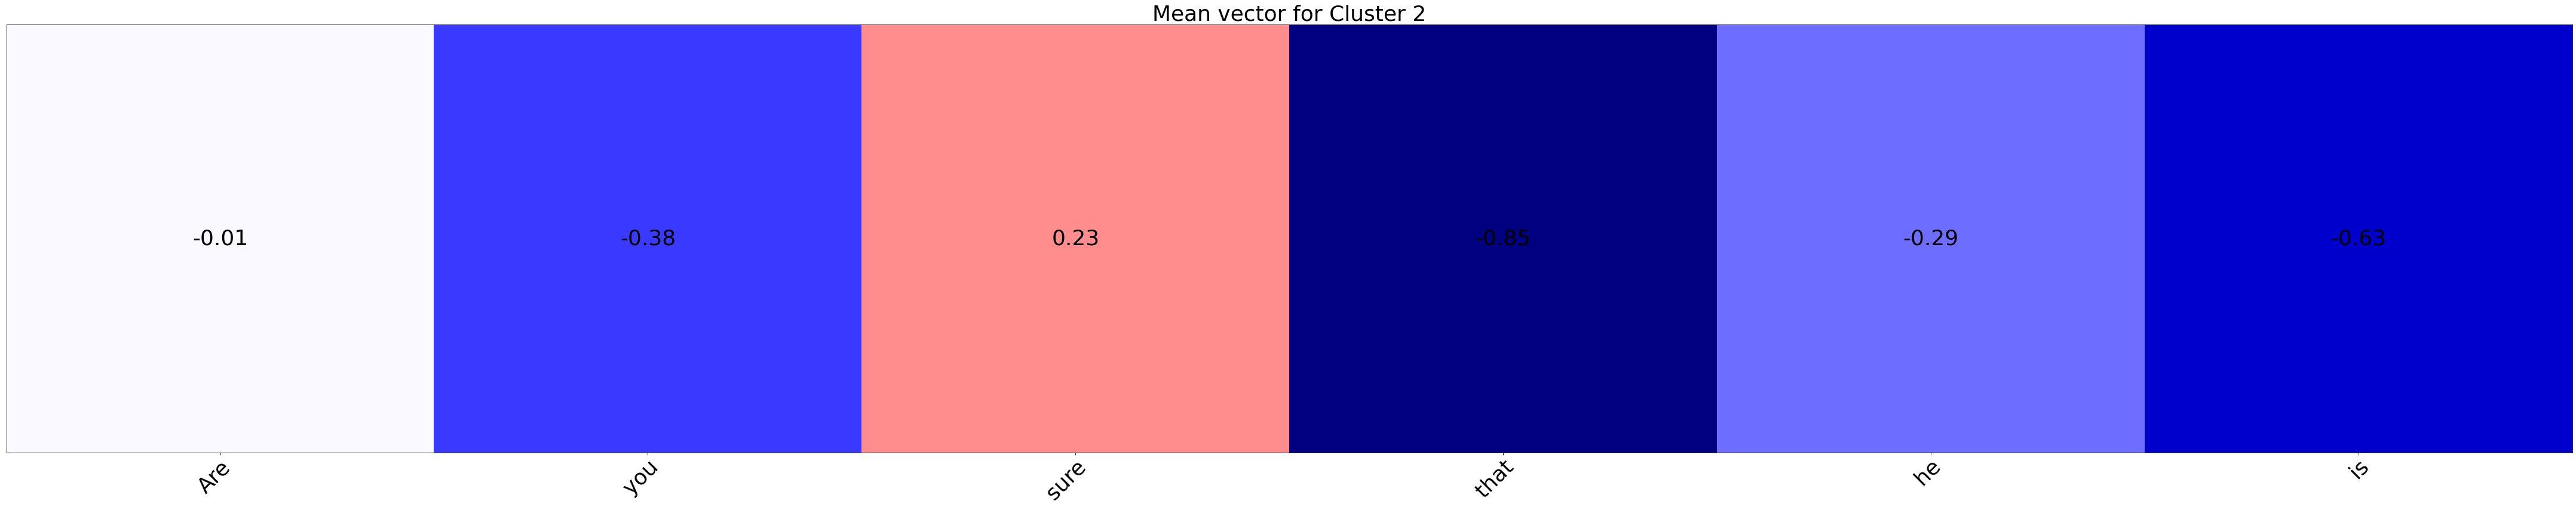

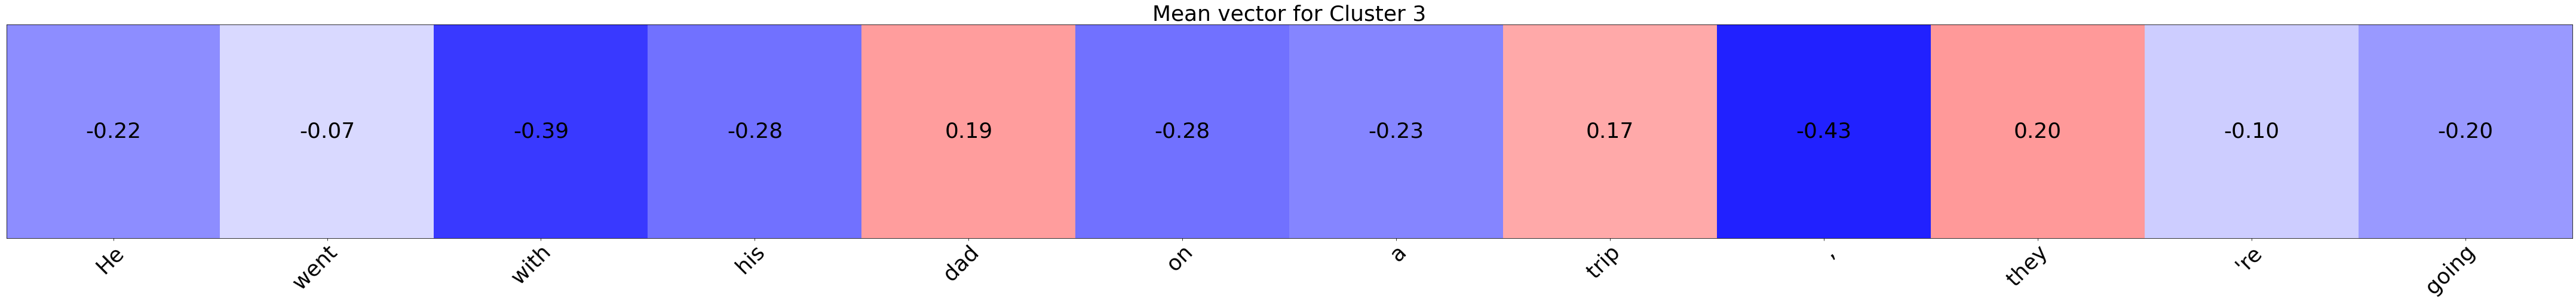

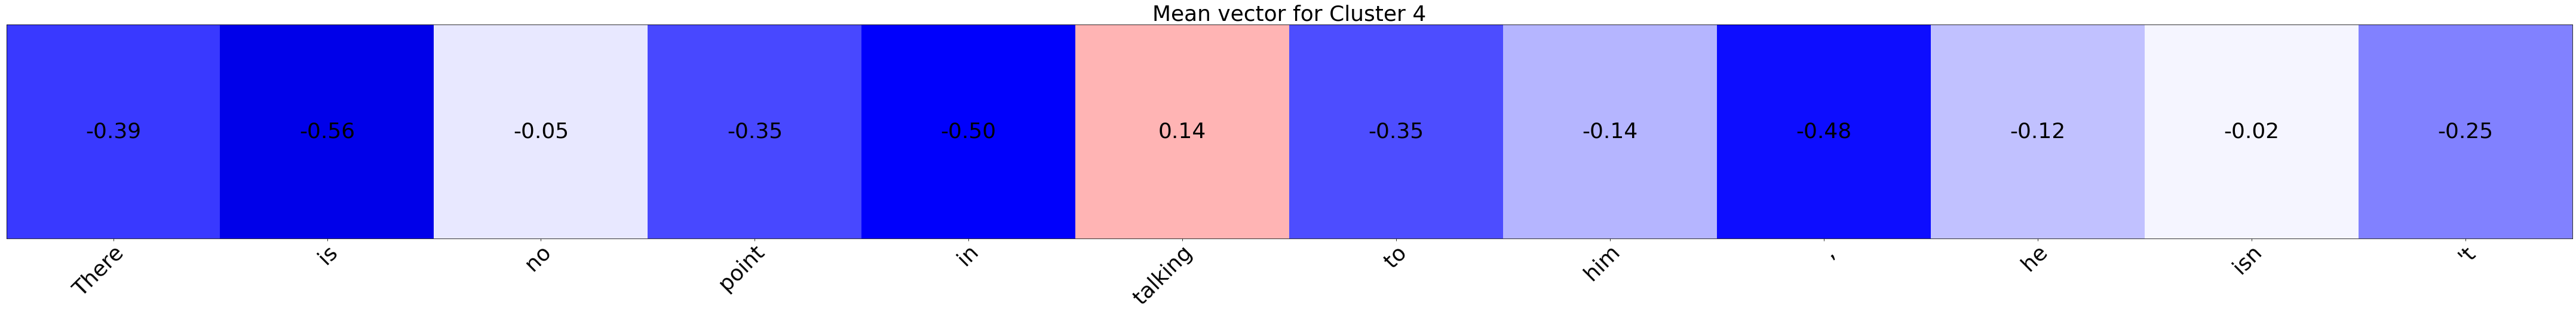

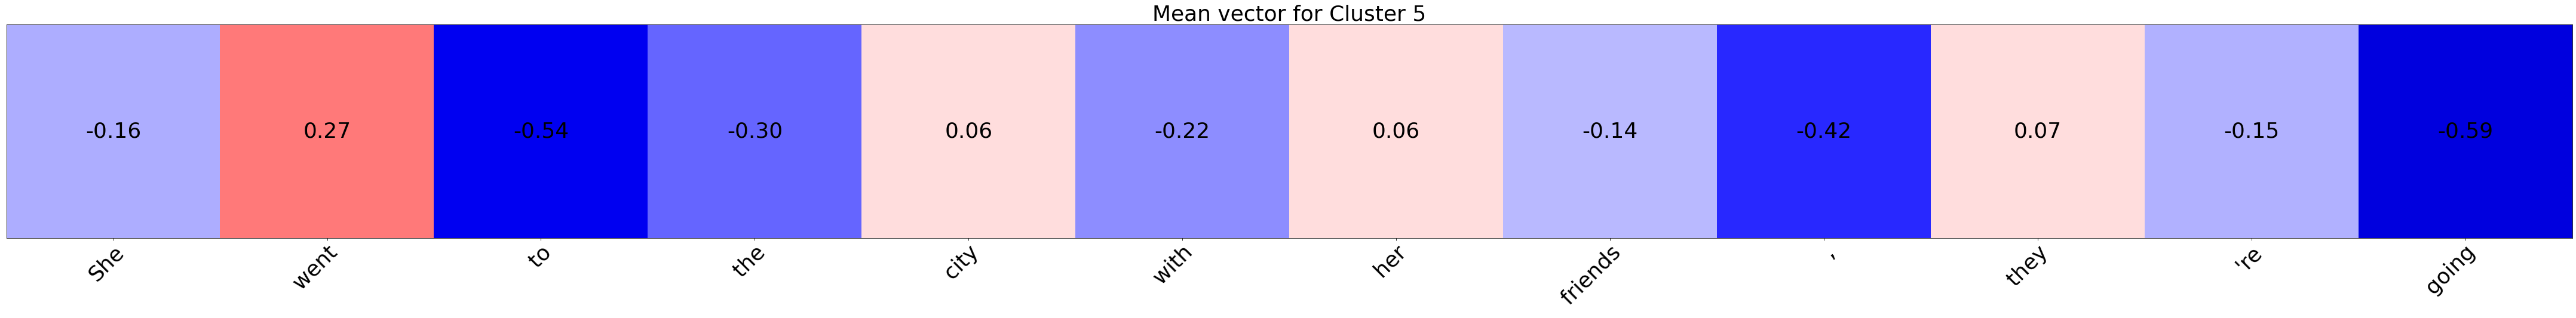

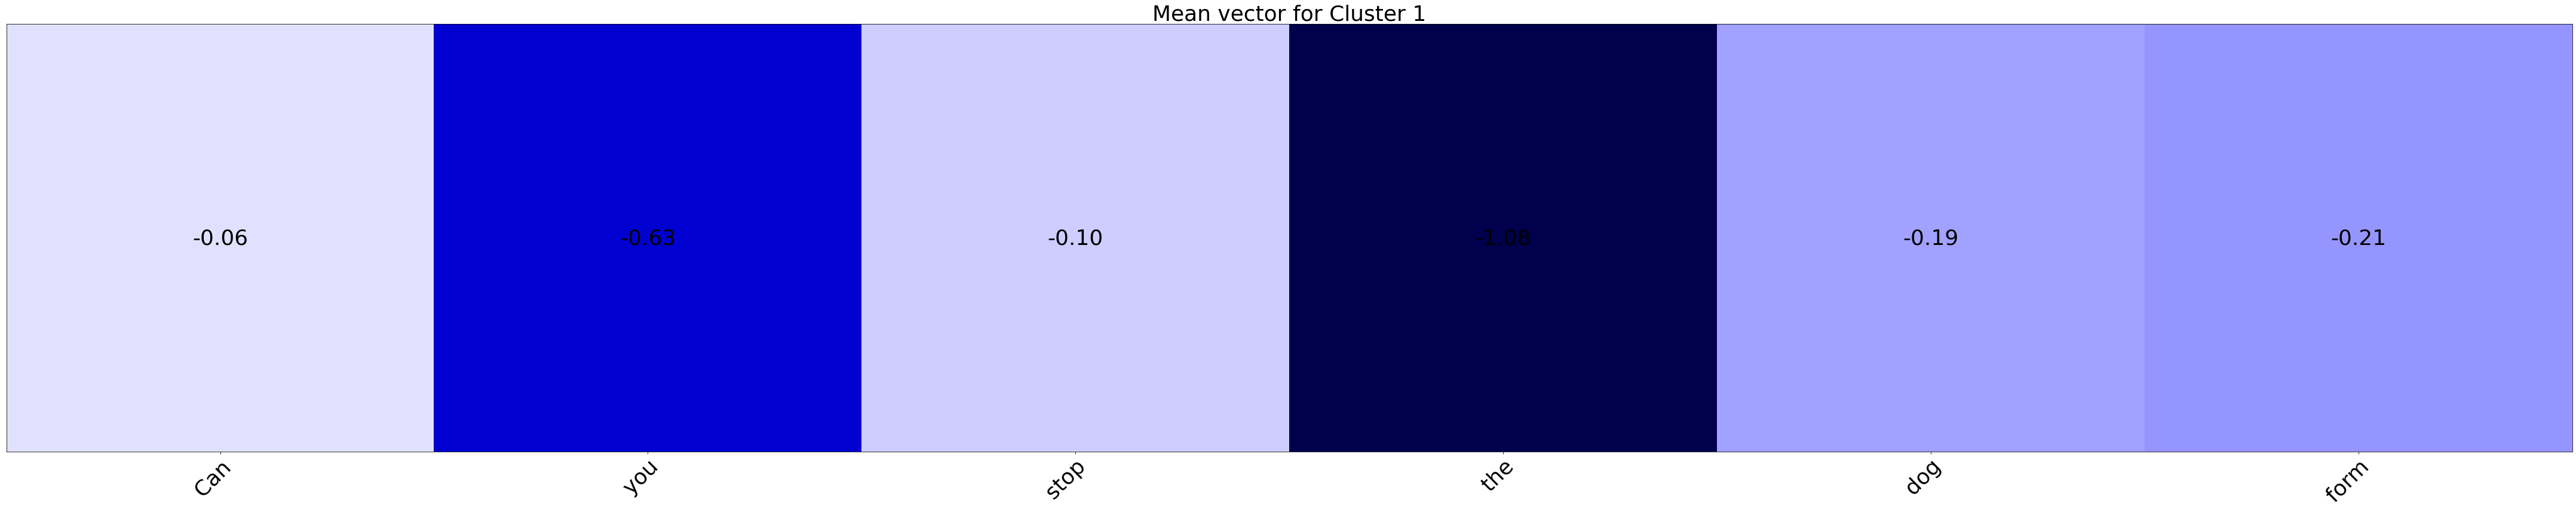

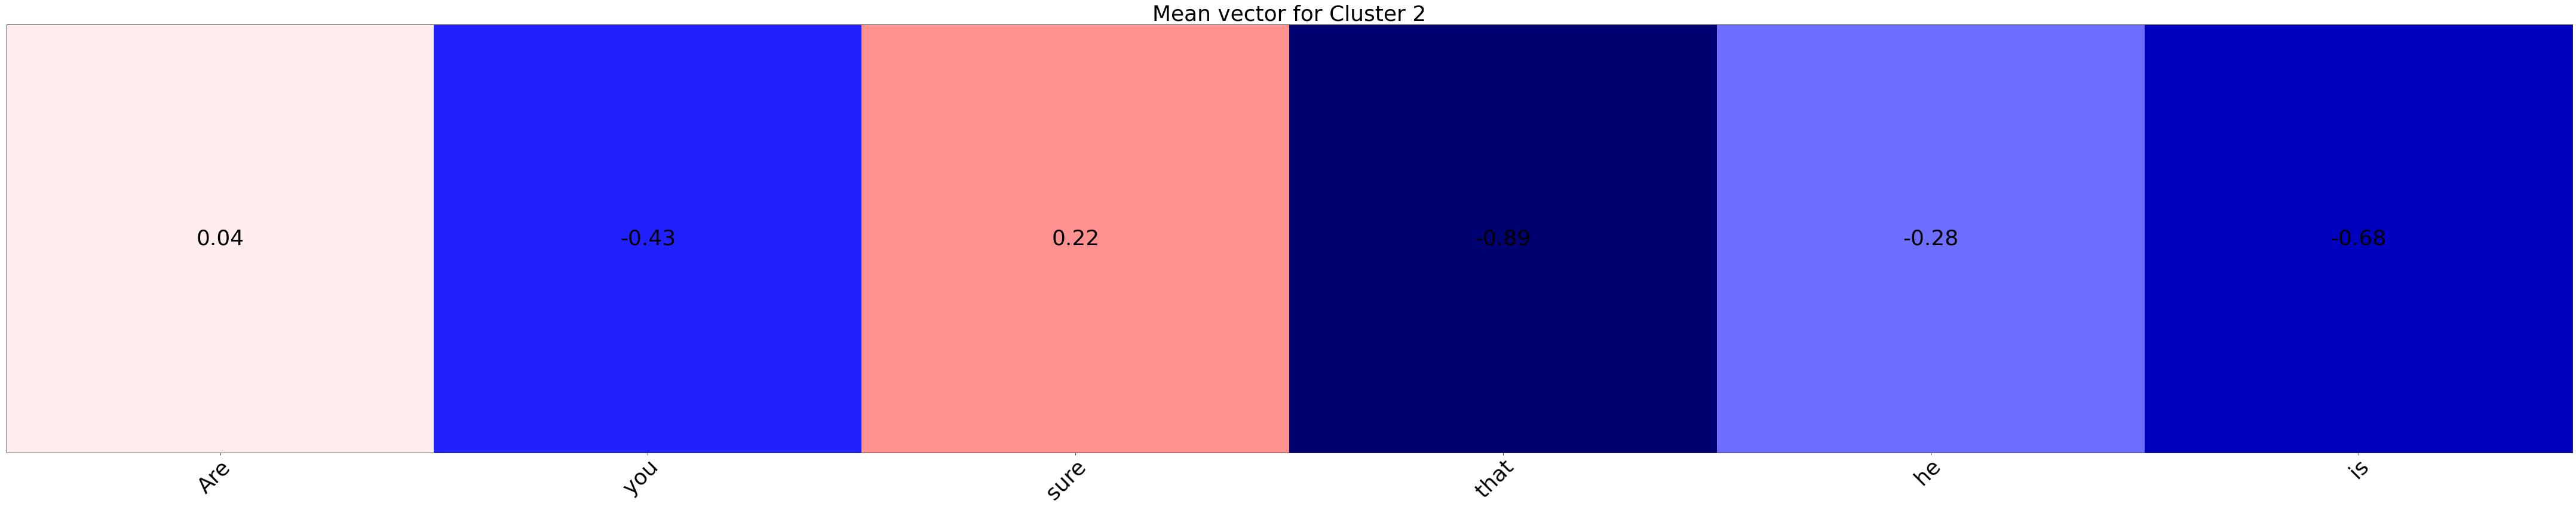

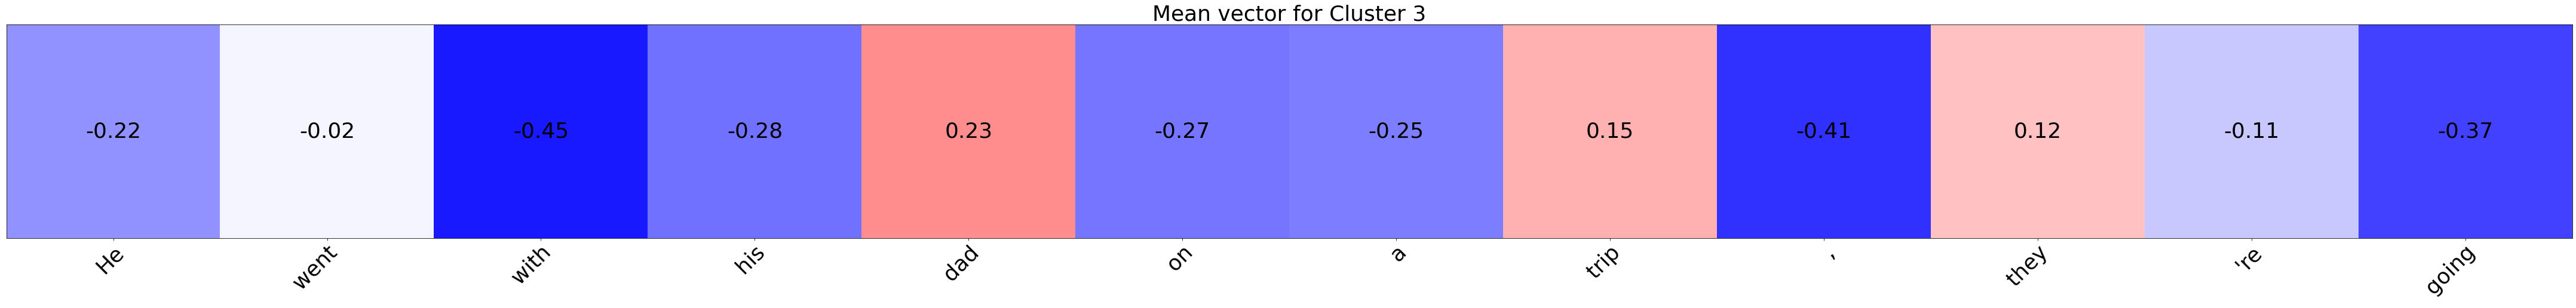

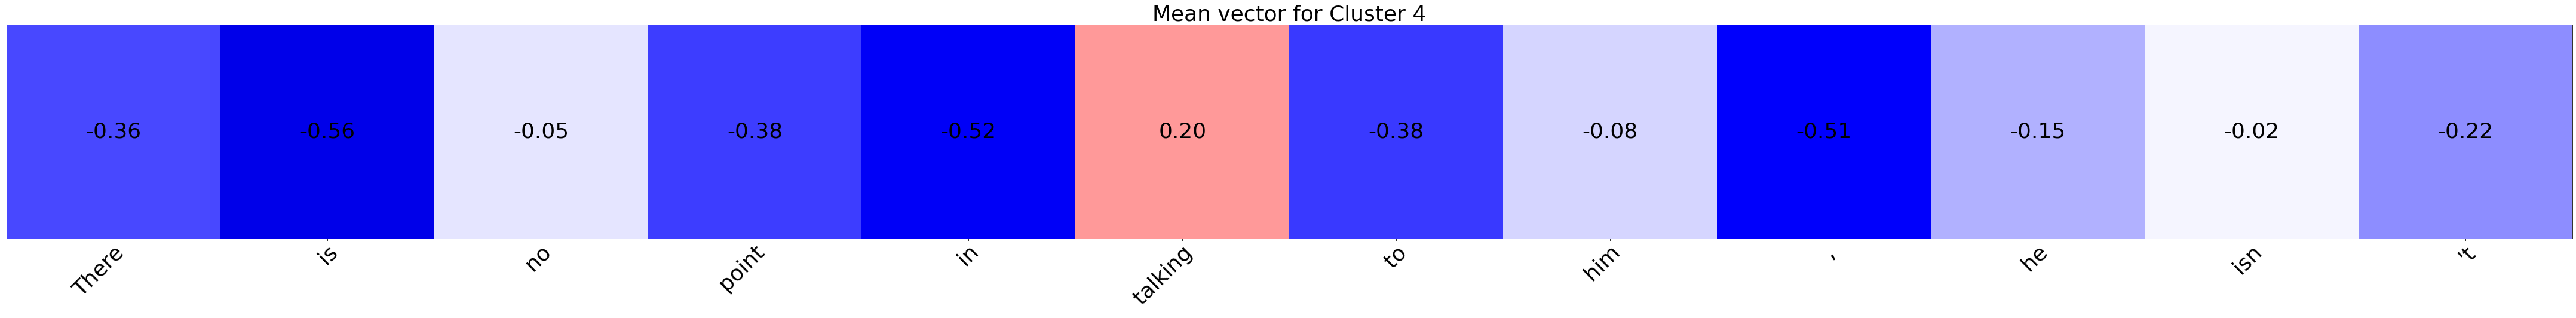

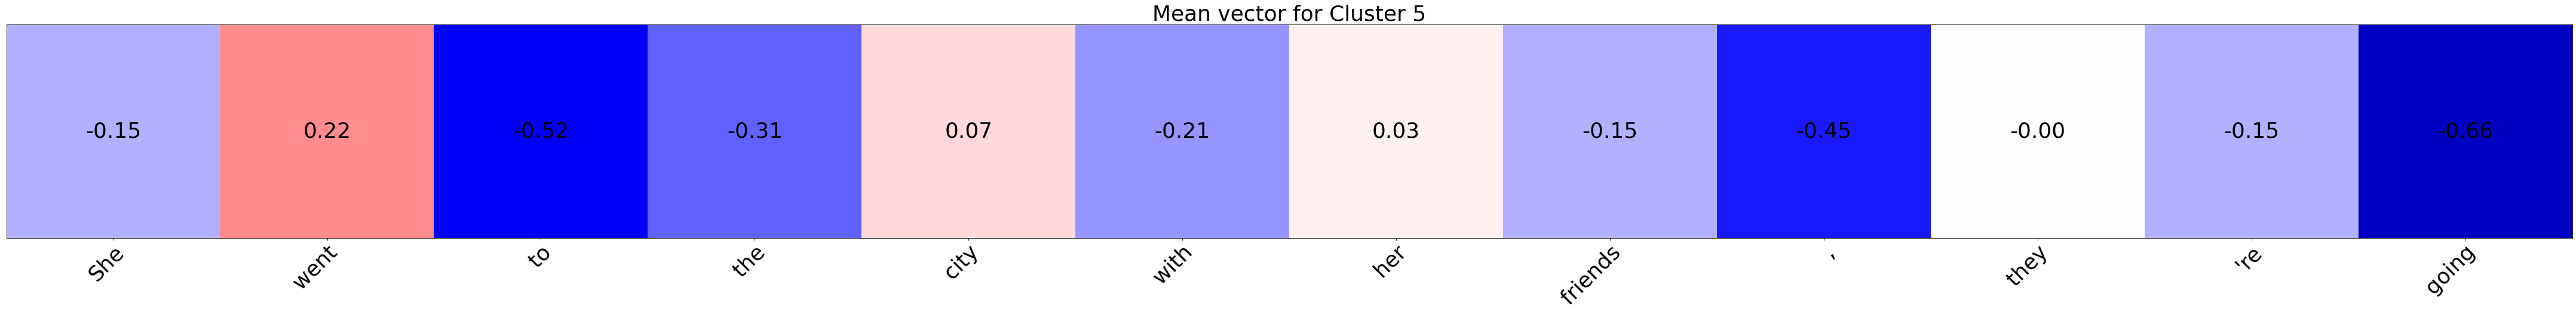

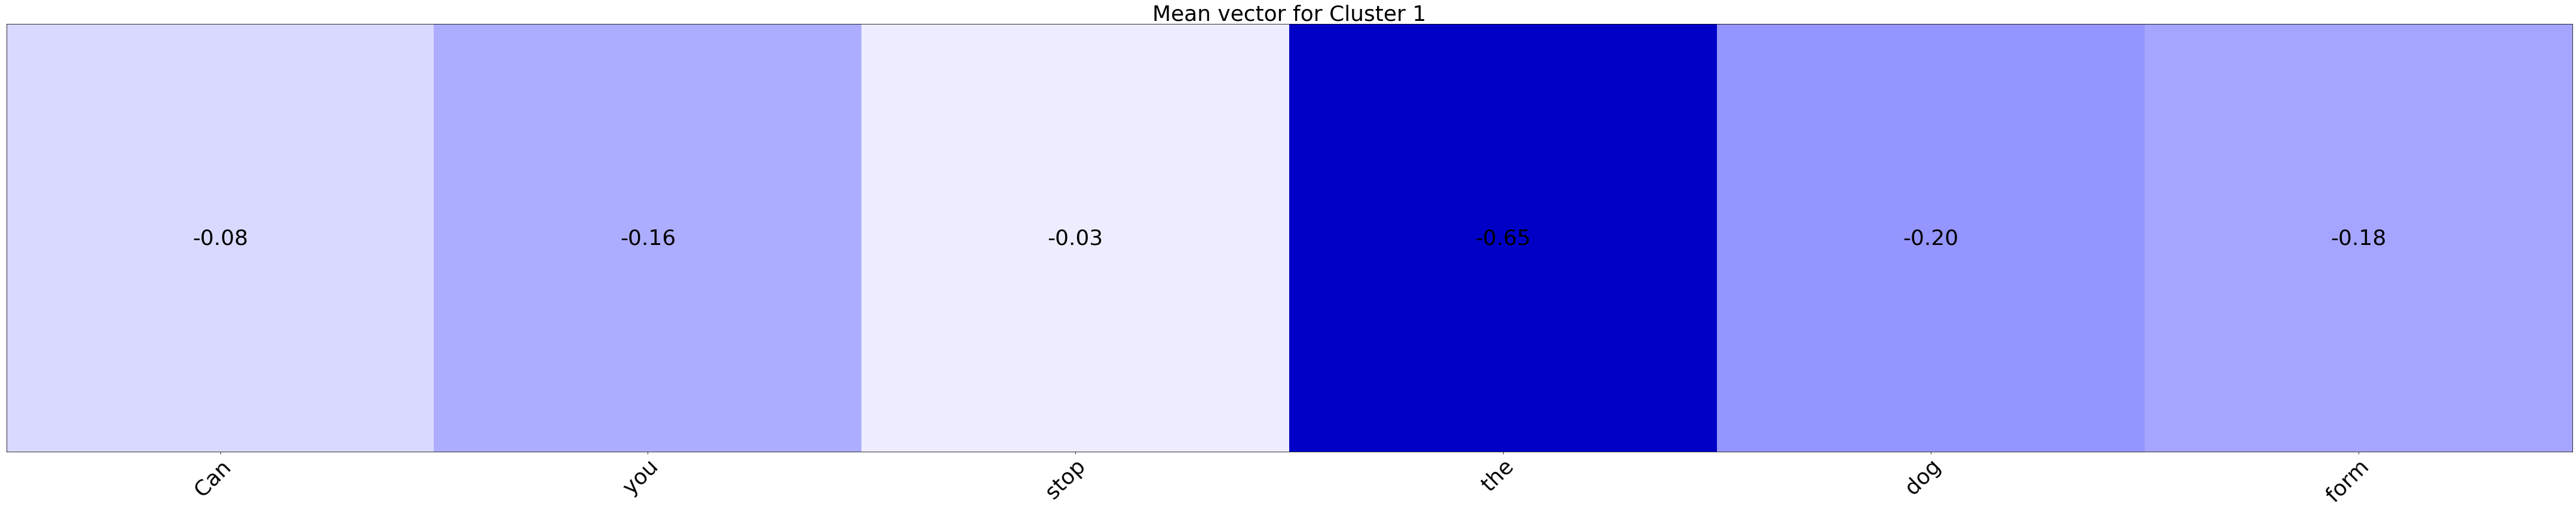

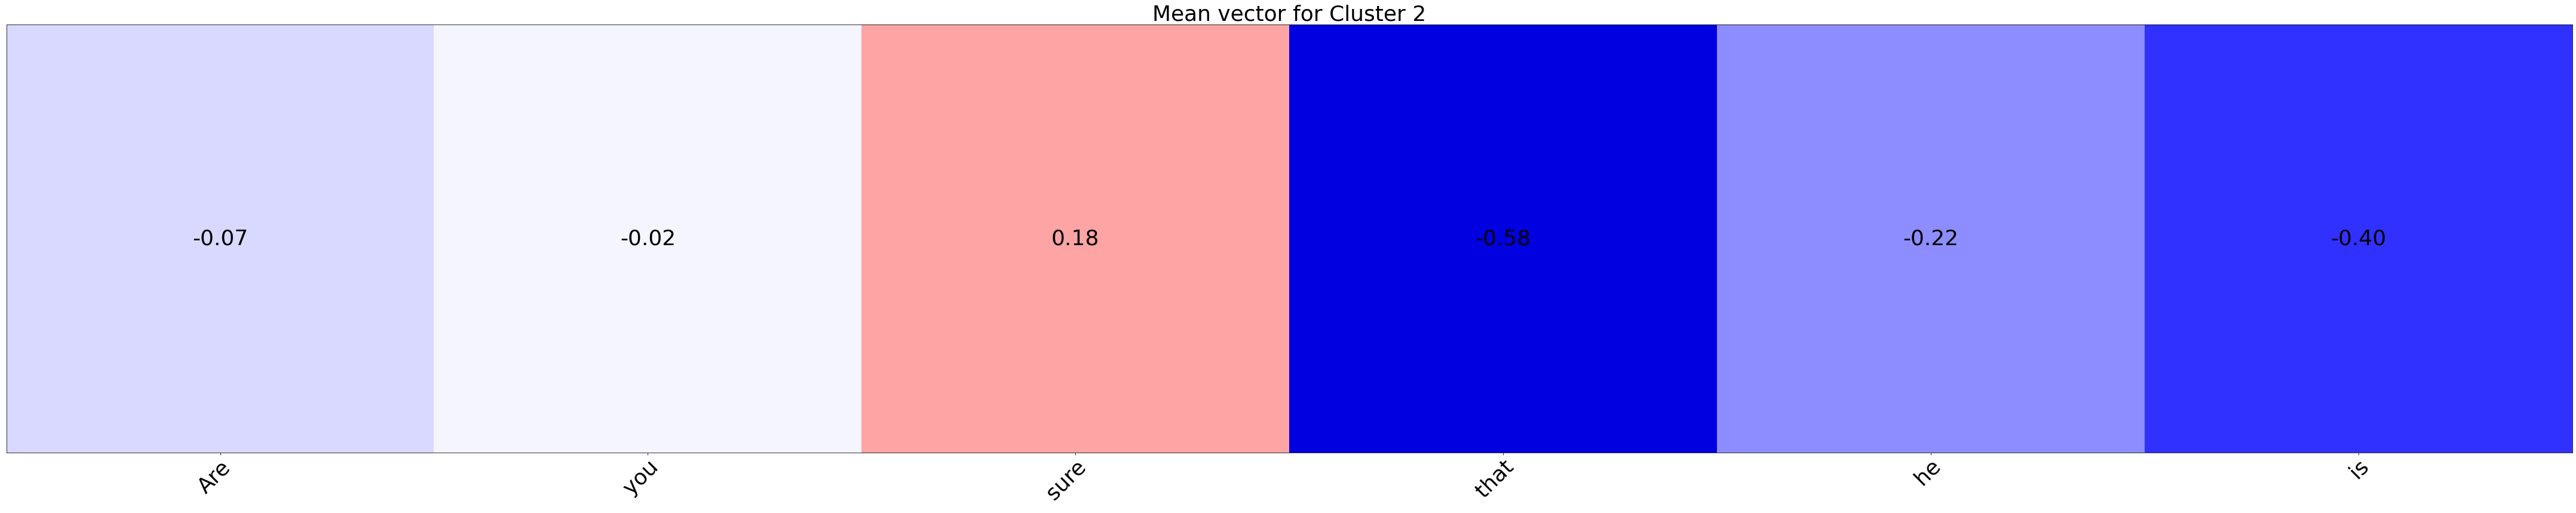

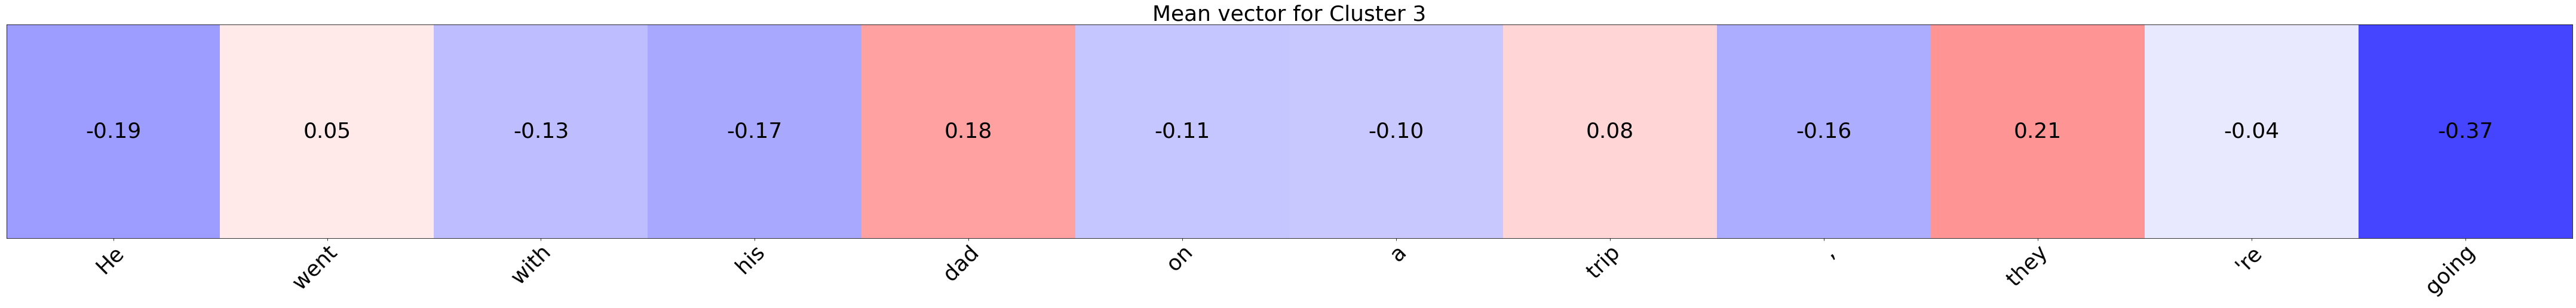

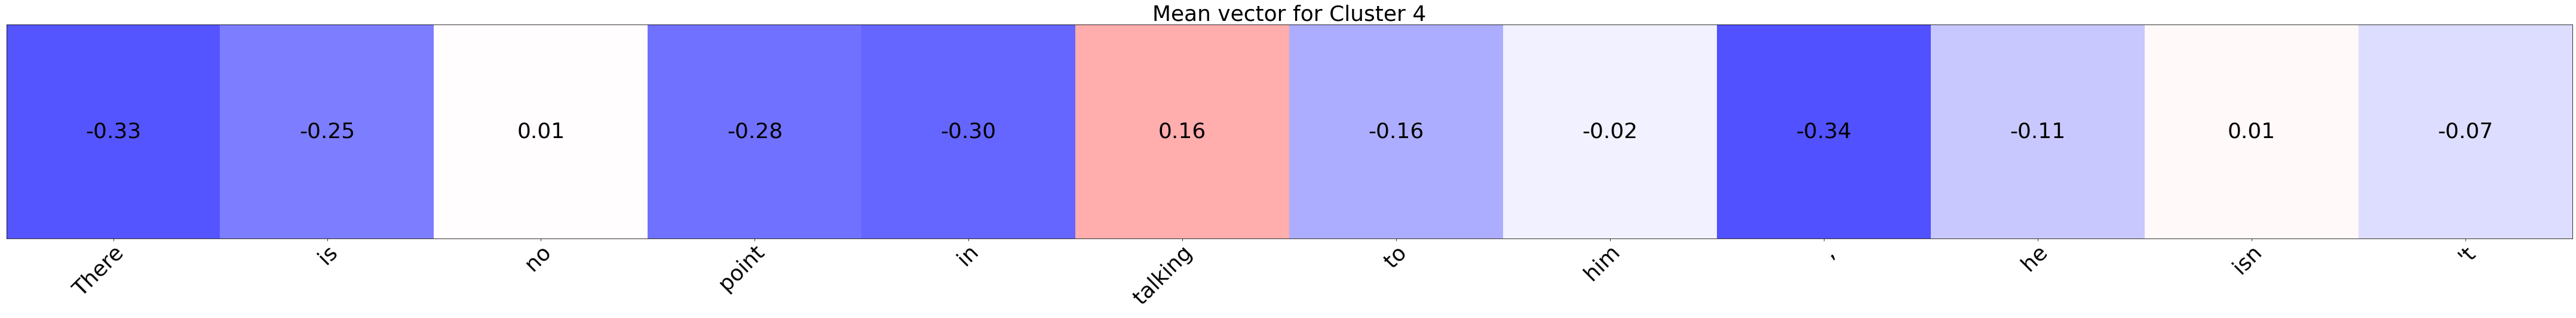

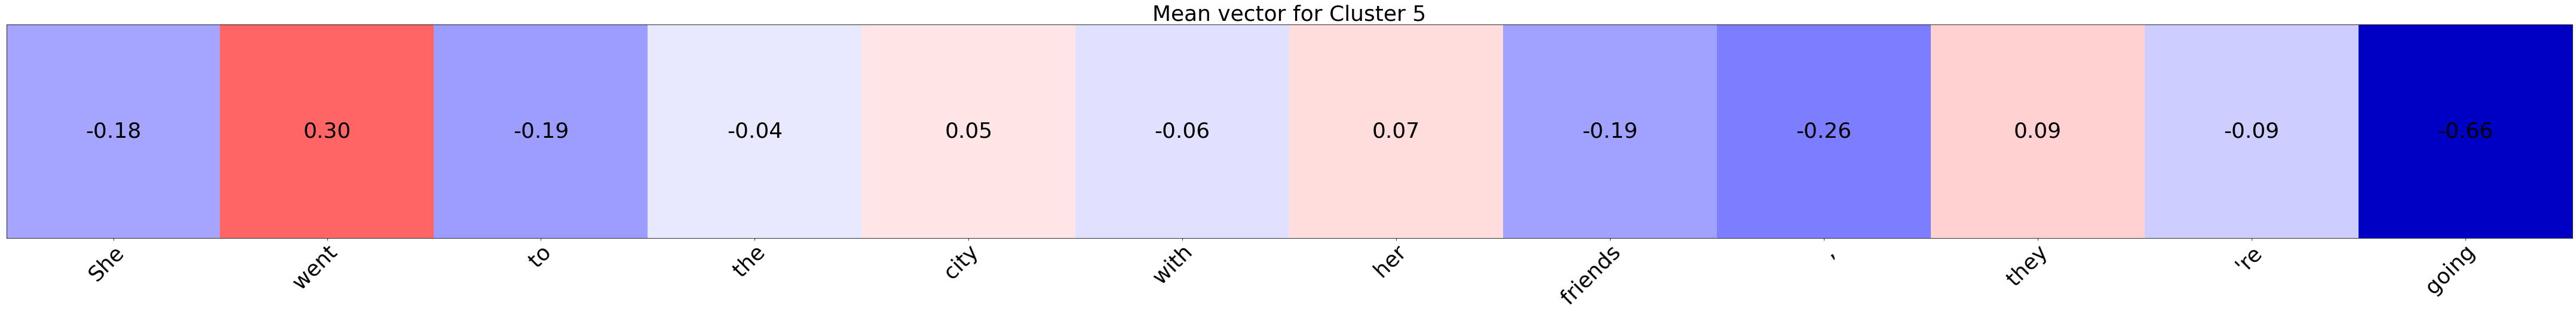

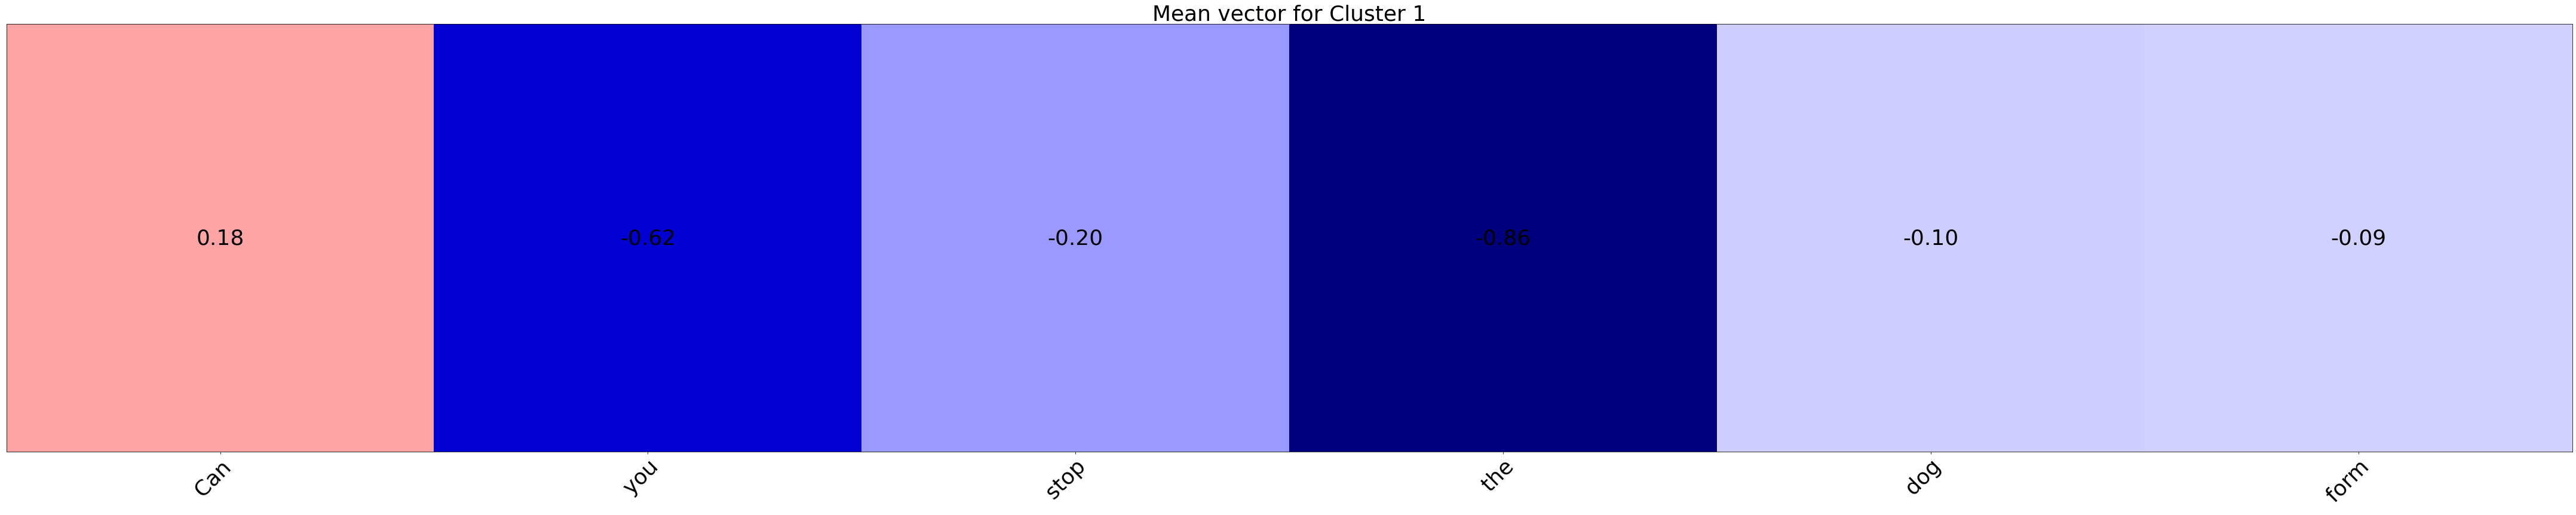

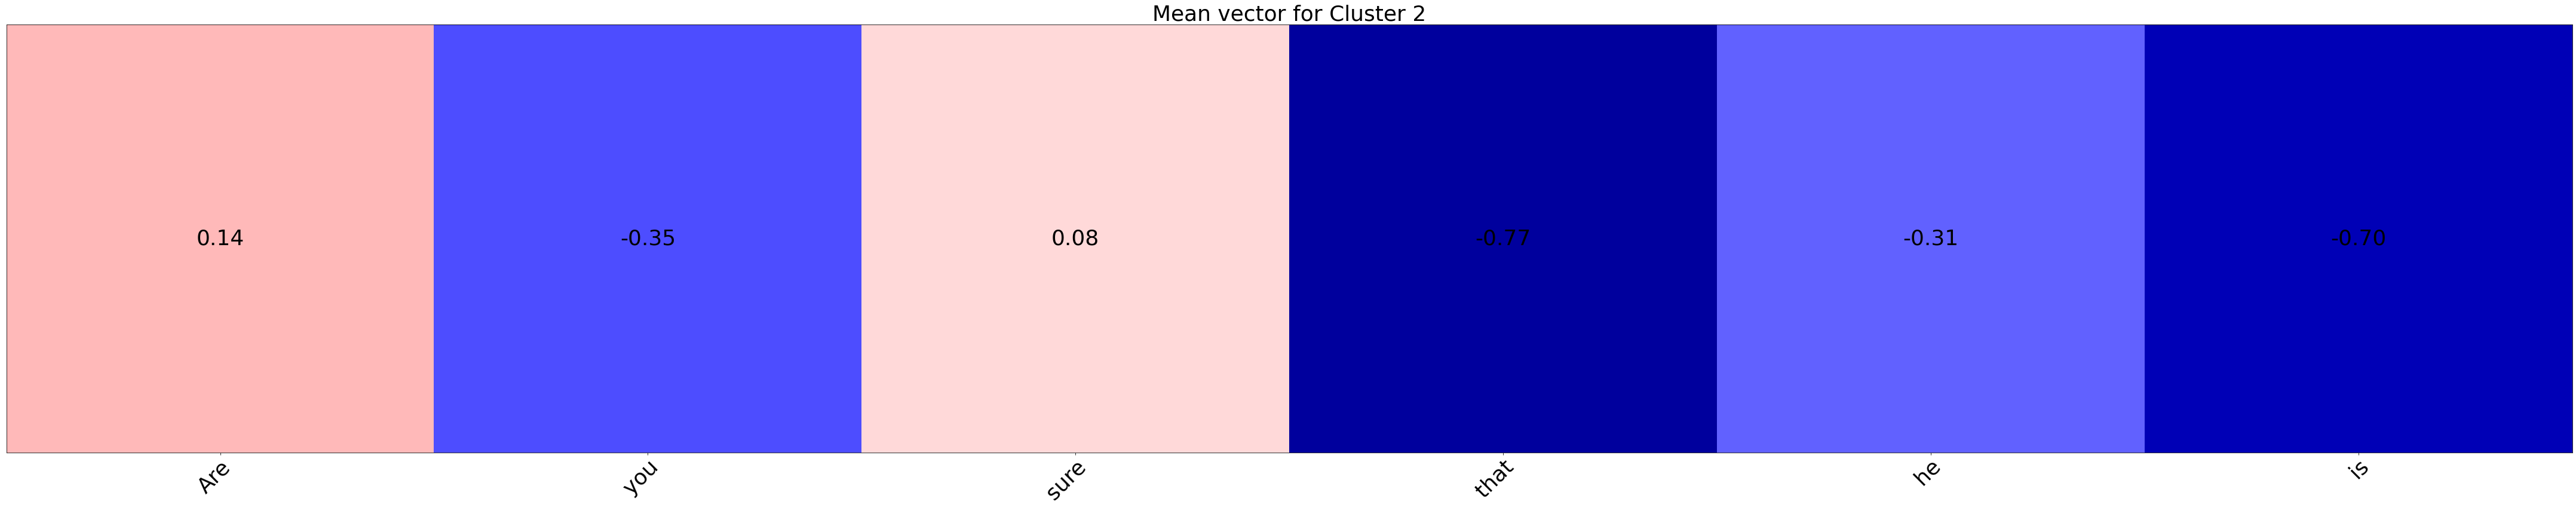

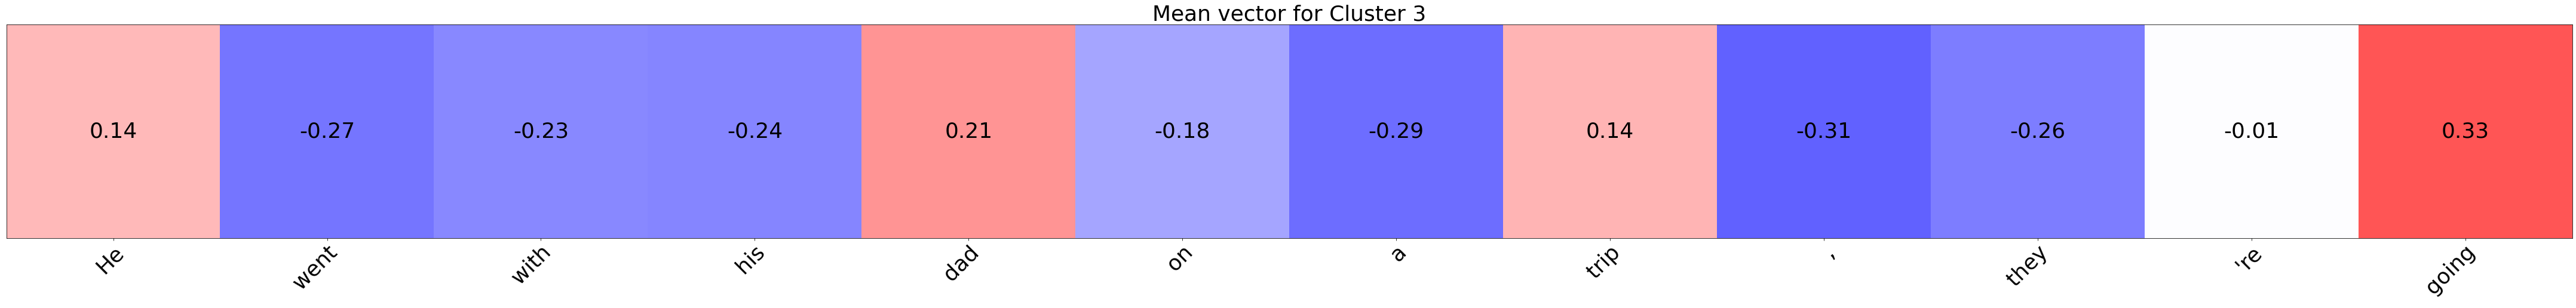

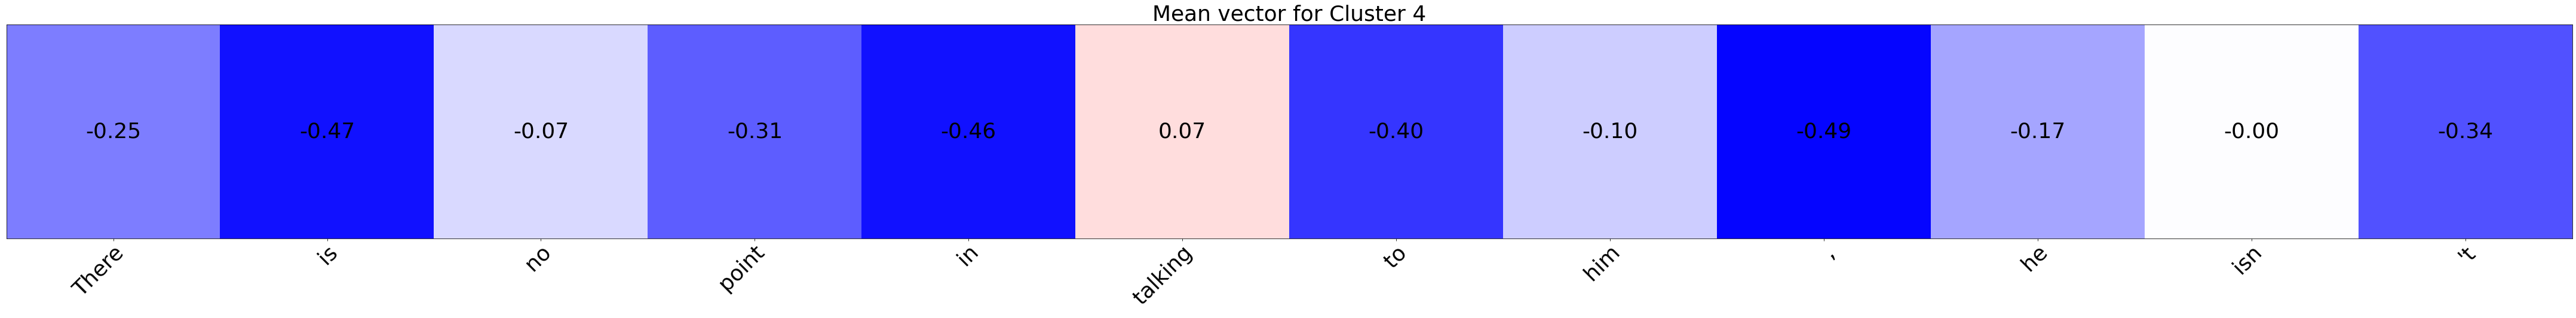

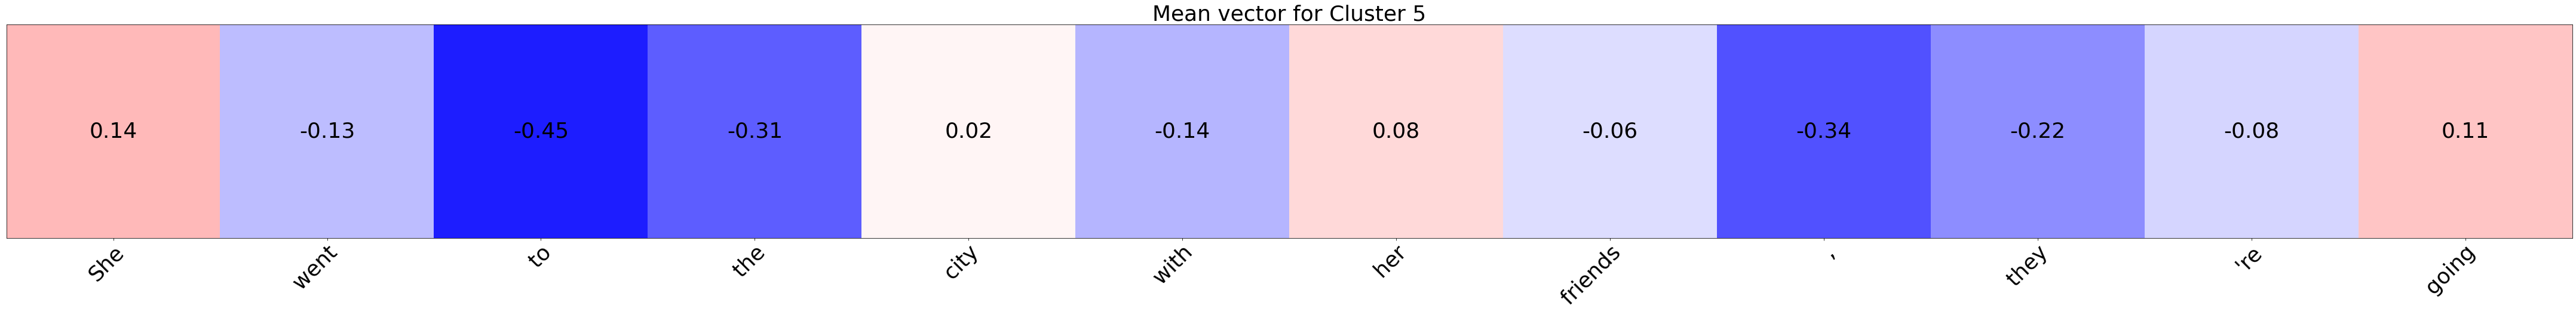

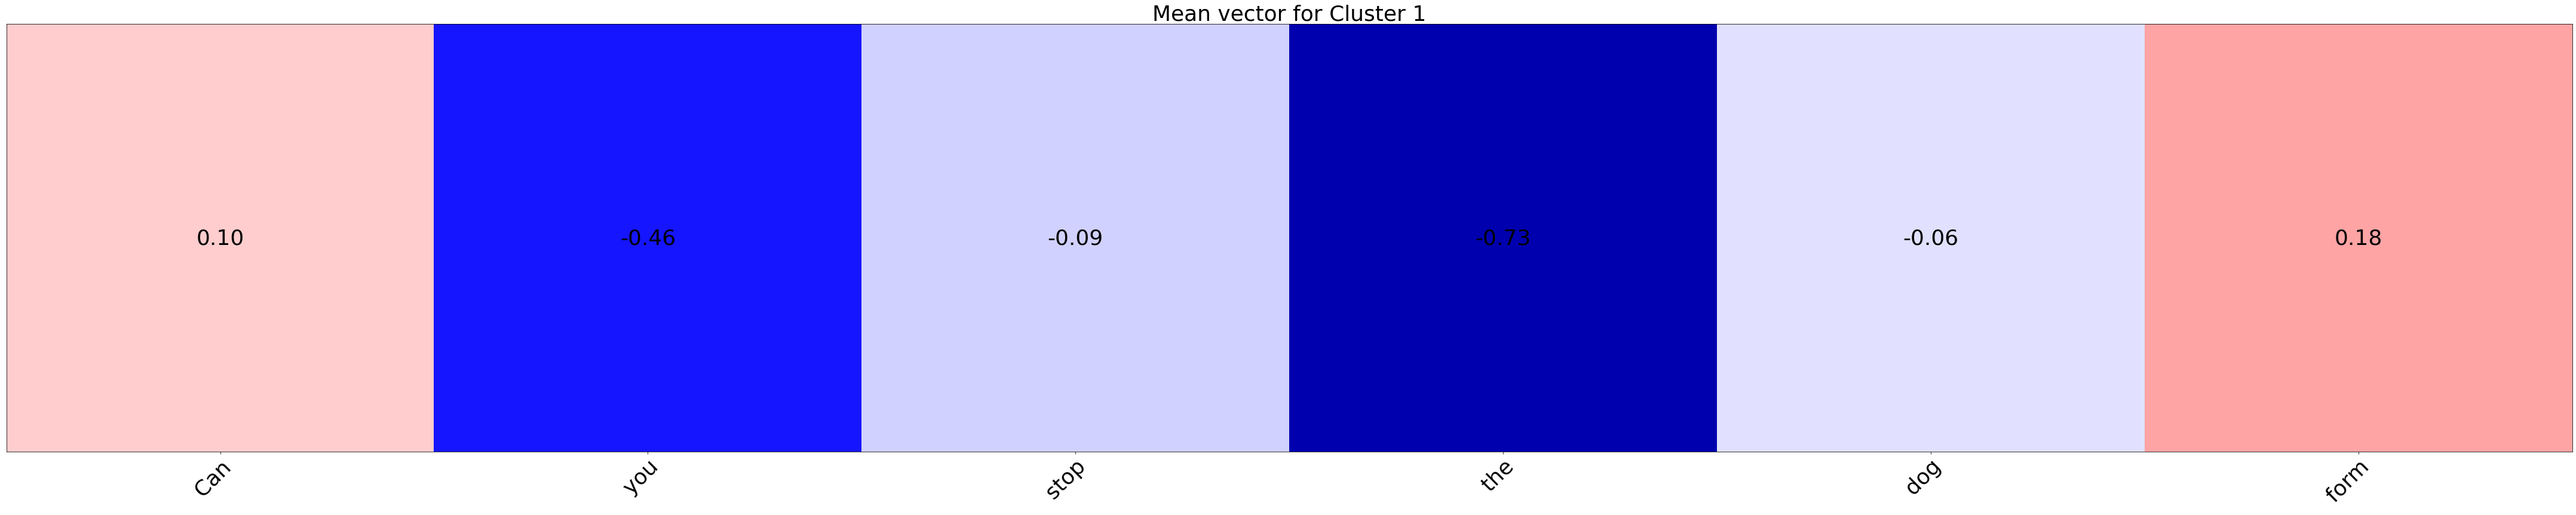

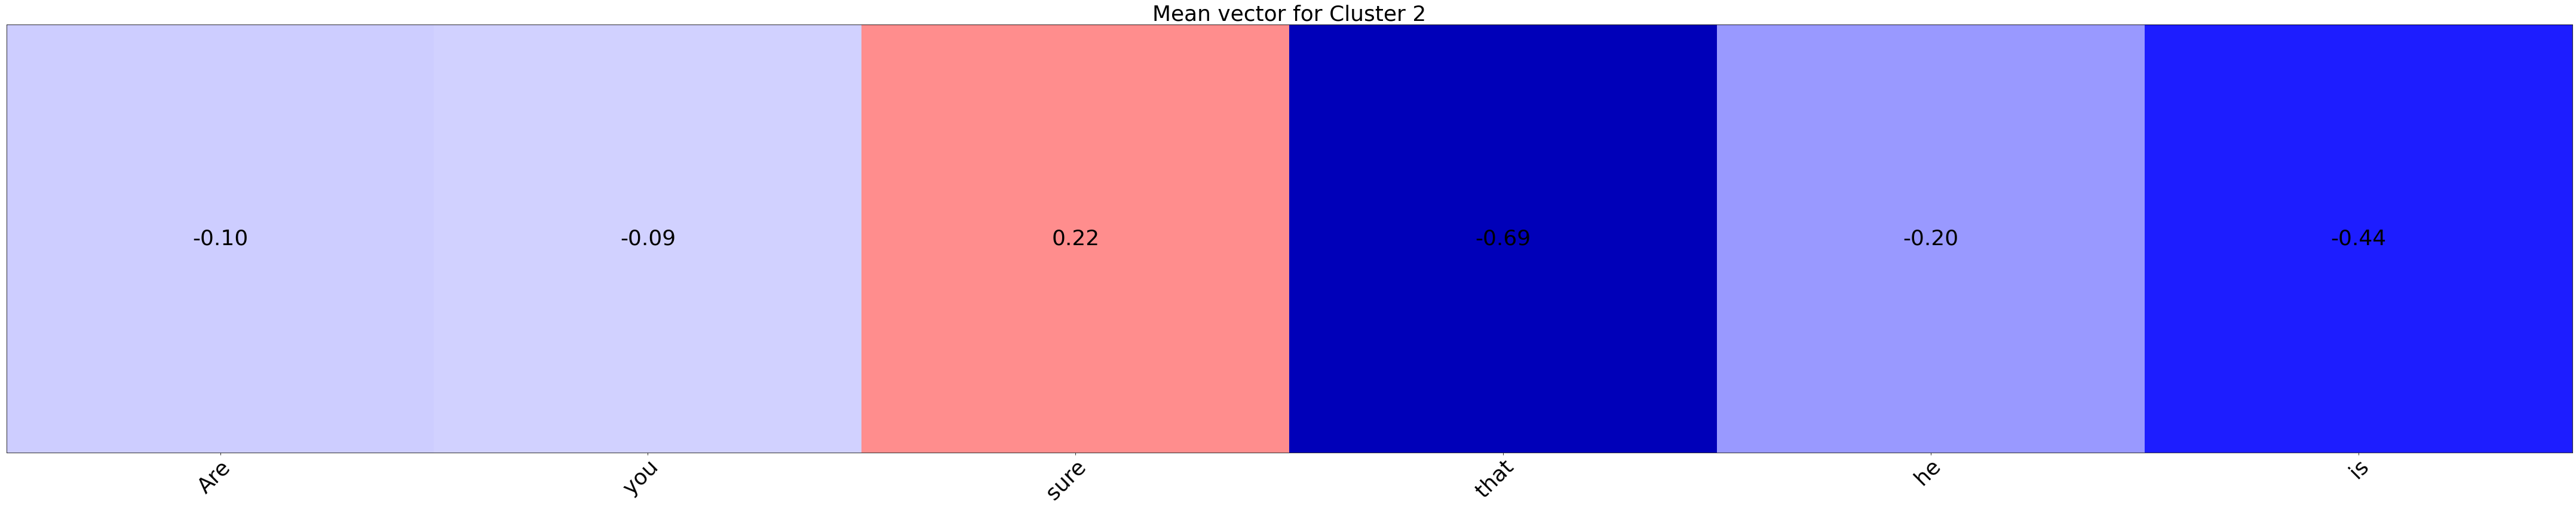

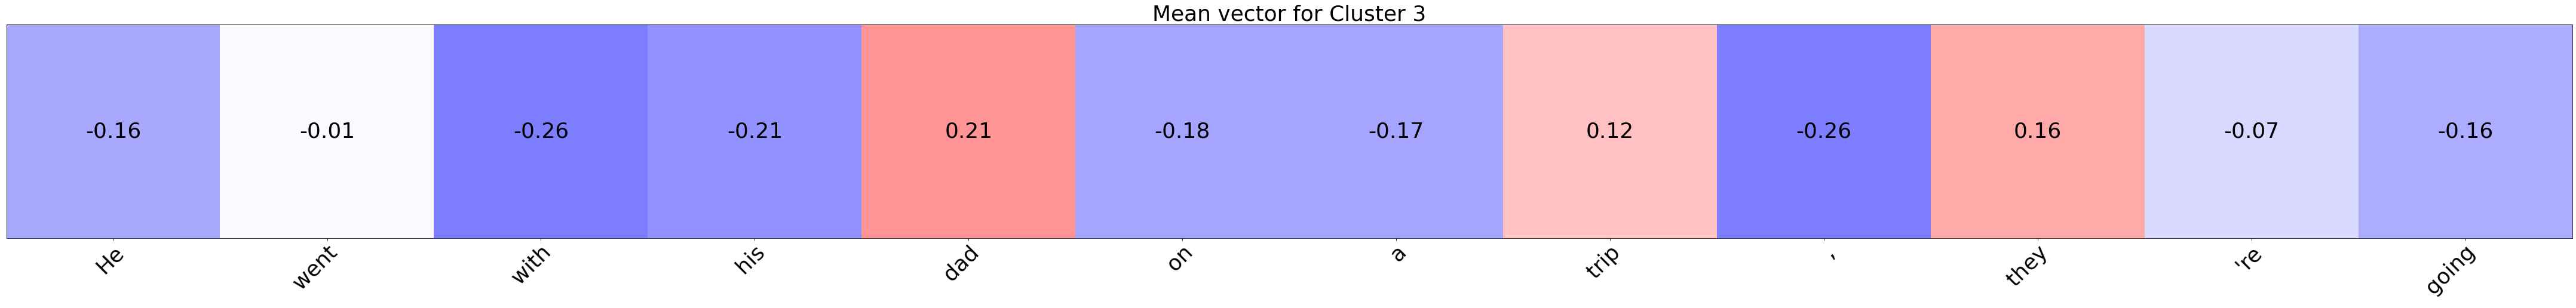

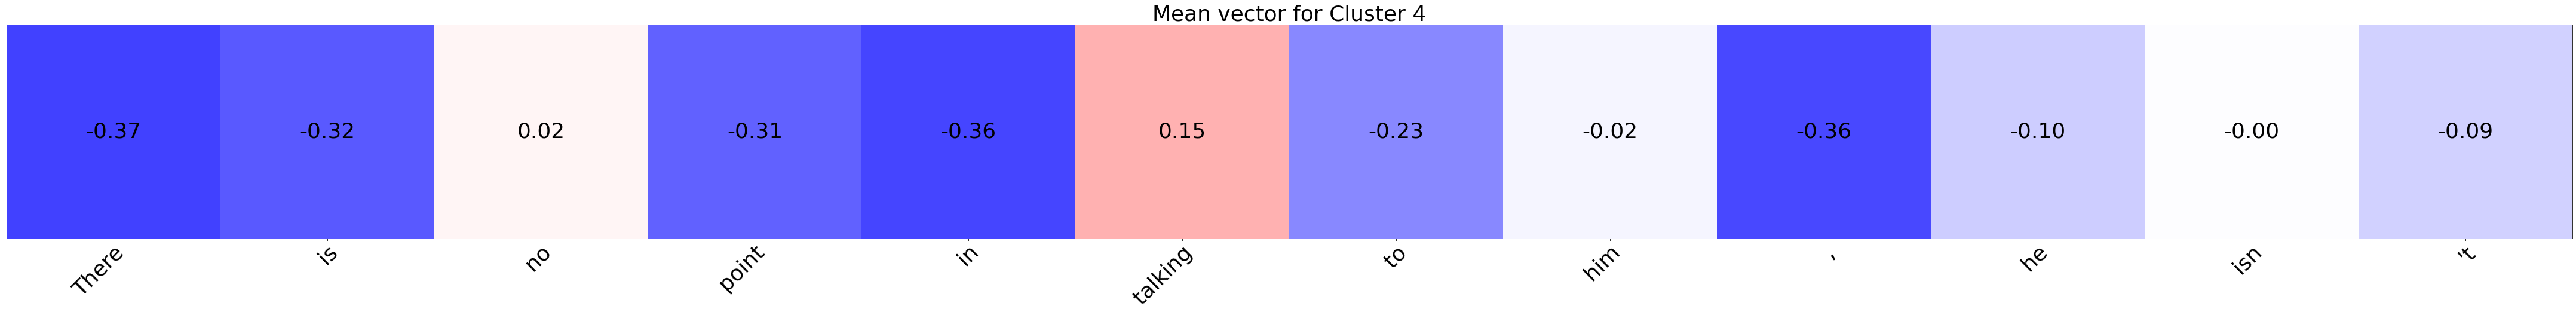

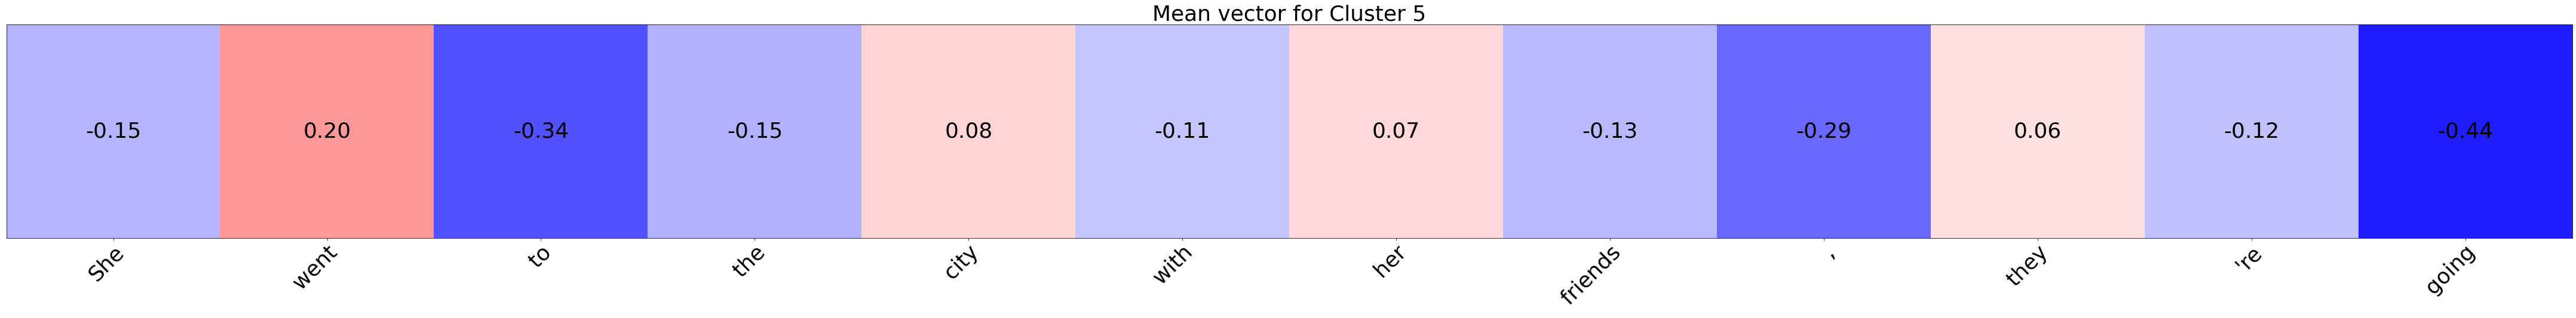

In [100]:
clusters = fcluster(linkage_matrix, t = 26.6, criterion= 'distance')
clusters_words = dict(sorted(map_words_to_clusters(top_words, clusters).items()))
for cluster_index, cluster_words in clusters_words.items():
        print(f"Cluster {cluster_index}: Cluster length {len(cluster_words)} :{cluster_words[:10]}")
cluster_means = [take_mean_vec(top_words, results, x,clusters_words) for x in clusters_words.keys()]
num_clusters = len(cluster_means)
subvector_lengths = [len(tokenizer(x)['input_ids']) for x in sentences]
split_cluster_means = [
    [
        item[sum(subvector_lengths[:i]): sum(subvector_lengths[:i + 1])]
        for i in range(len(subvector_lengths))
    ]
    for item in cluster_means
]
for clustermean in split_cluster_means:
    for i,sentencey in enumerate(sentences):
            visualize(clustermean[i], tokenizer,[tokenizer(sentencey)['input_ids']], print_text=True, title=f"Mean vector for Cluster {i+1}")

Cluster -1: Cluster length 8113 :['the', 'of', 'and', 'in', 'to', 'a', 'was', 'on', 'for', 'as']
Cluster 0: Cluster length 300 :['be', 'but', 'are', 'or', 'who', 'about', 'only', 'no', 'can', 'up']
Cluster 1: Cluster length 154 :['series', 'area', 'final', 'due', 'according', '15', 'again', '11', '16', '18']
Cluster 2: Cluster length 1433 :['united', 'century', 'march', 'john', 'storm', 'club', 'league', 'england', 'played', 'published']


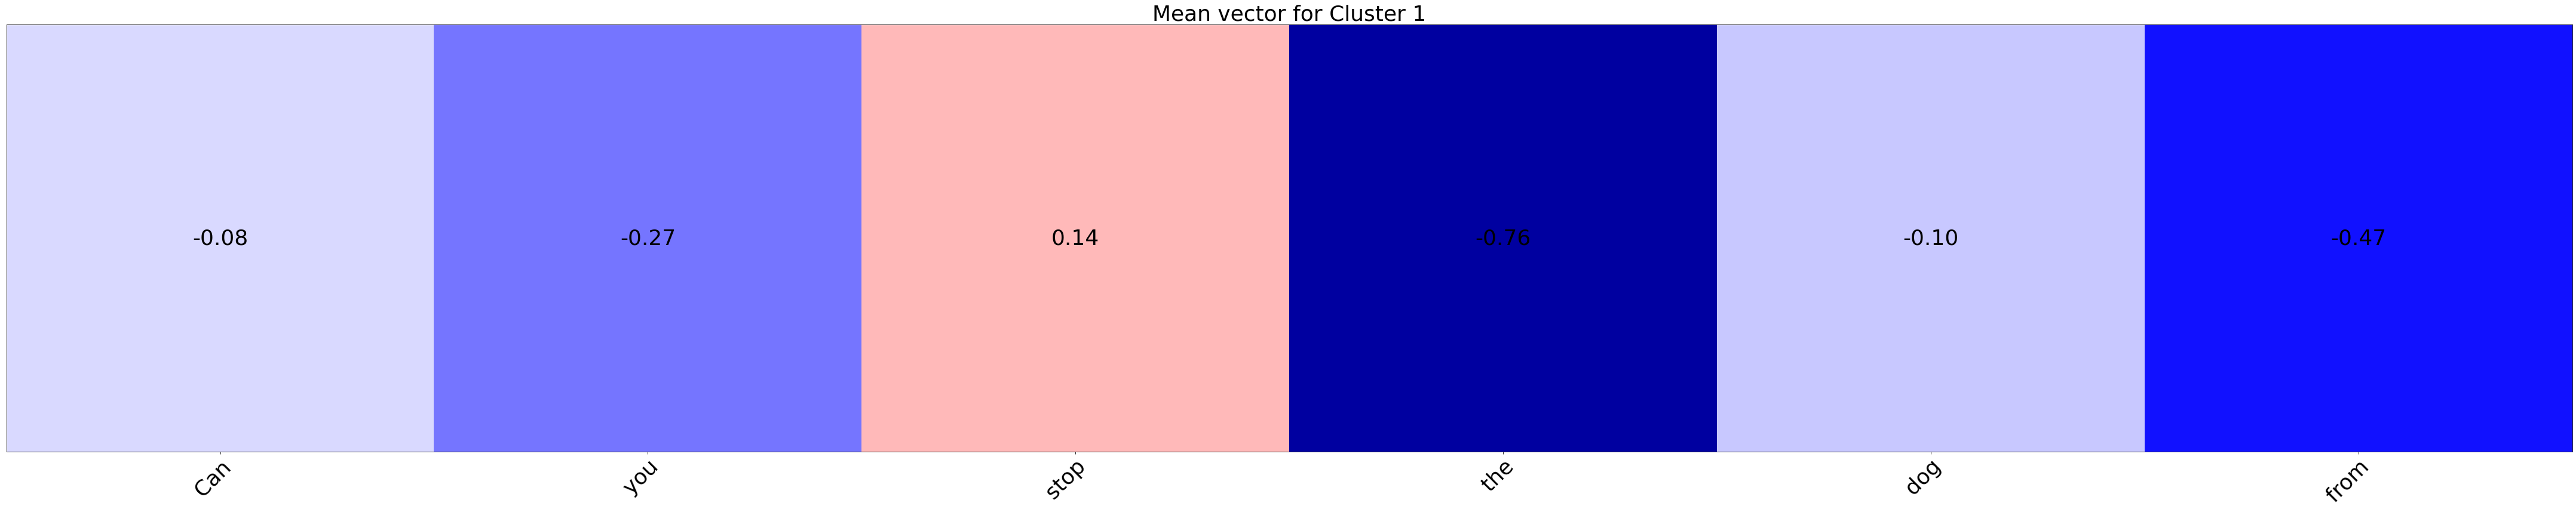

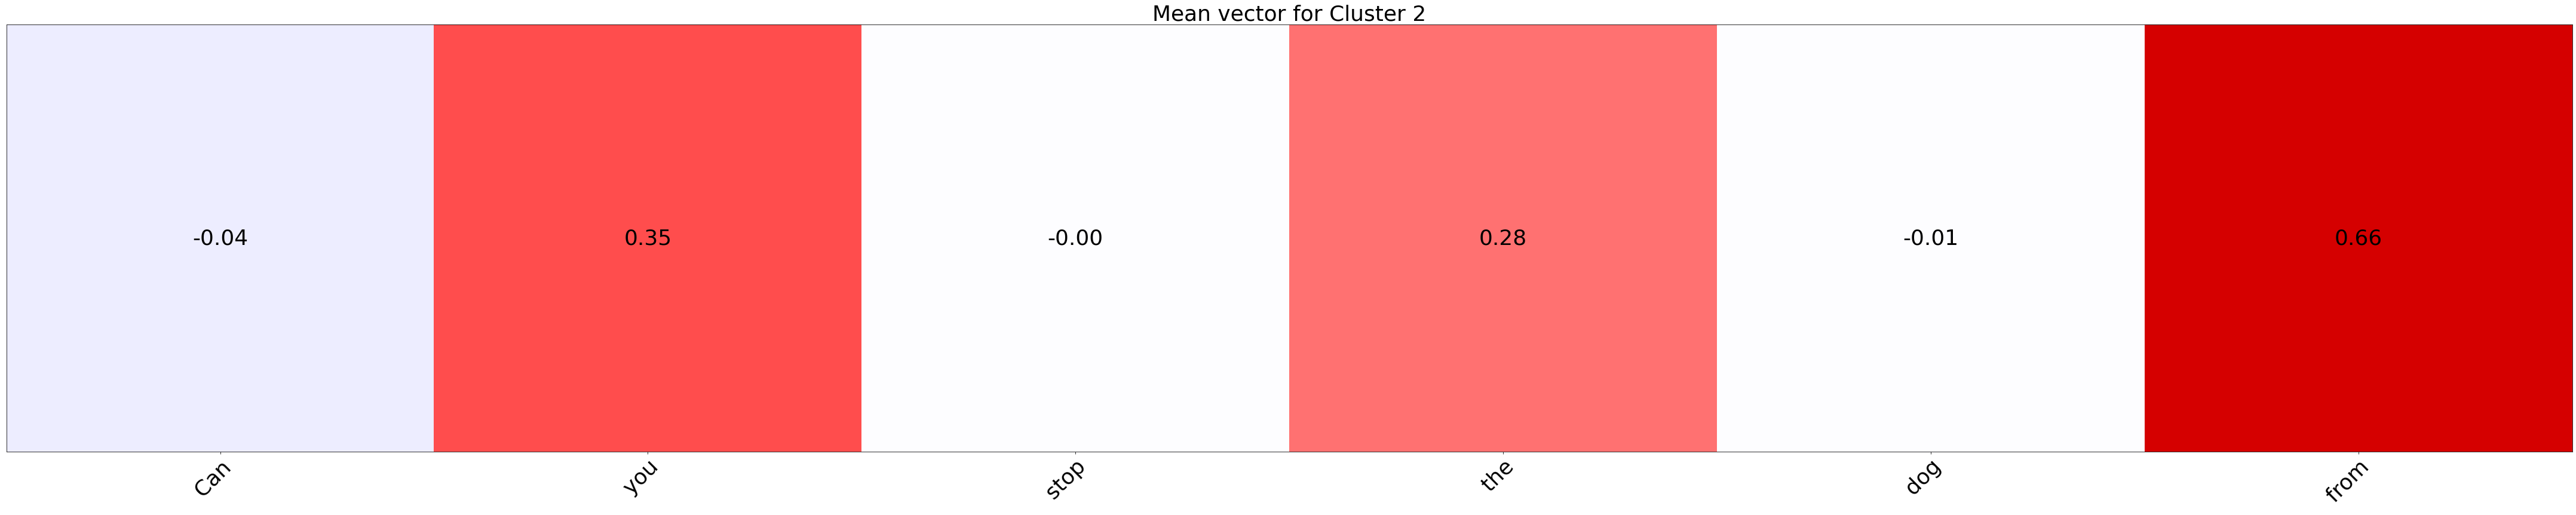

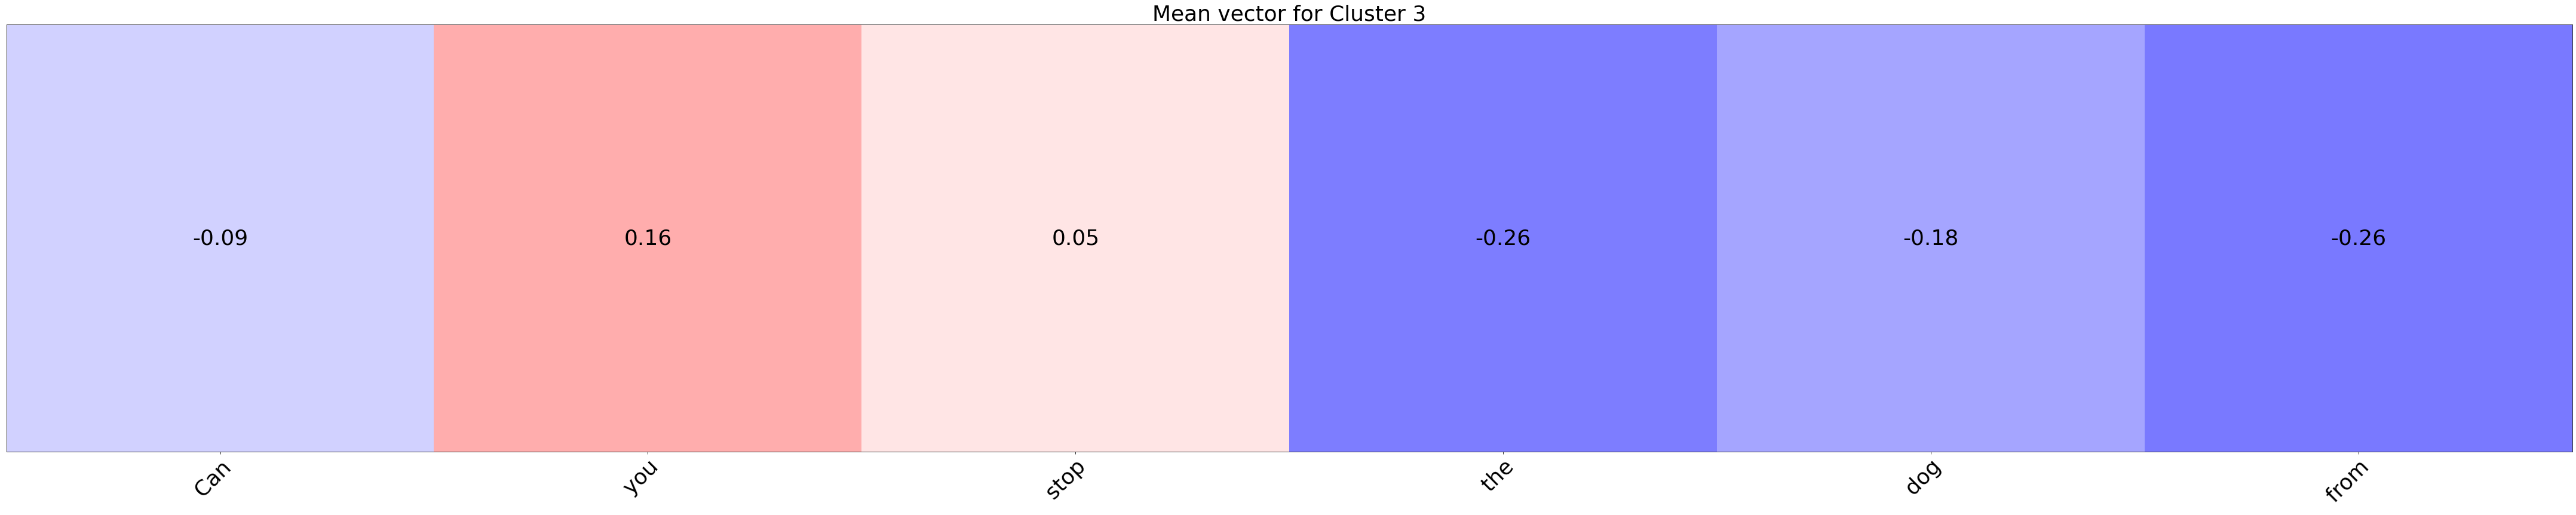

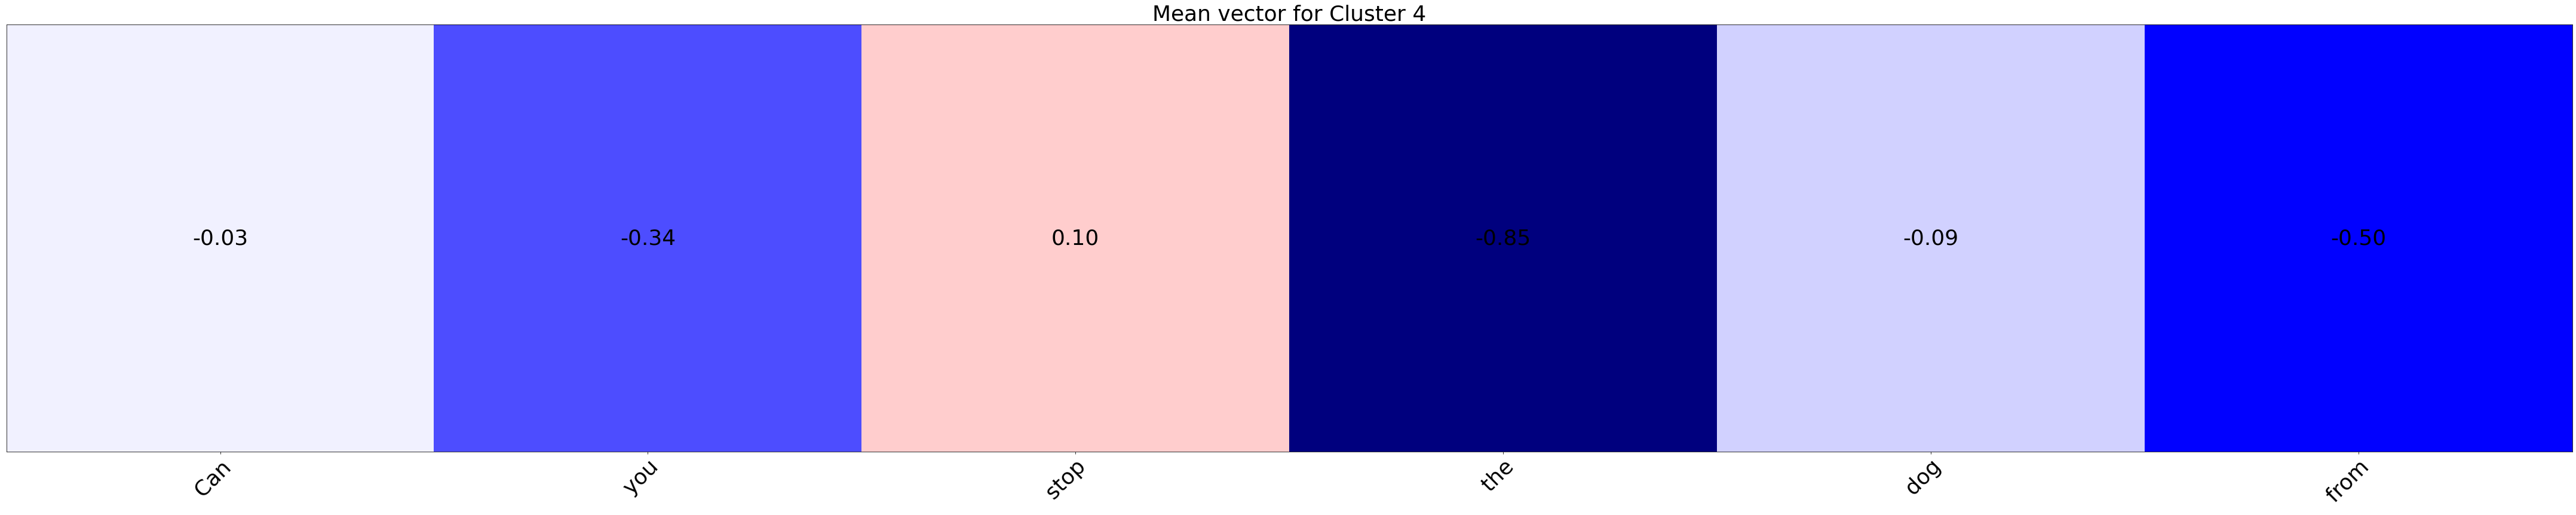

In [75]:
i = 0
visualize_clusters(top_words,Small_sample[i], result_list[i], result_list[i], 73 )

In [63]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors = 2)
nbrs = neigh.fit(results)
distances, indices = nbrs.kneighbors(results)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x14f6a4101d30>
Traceback (most recent call last):
  File "/sw/arch/Centos8/EB_production/2021/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/arch/Centos8/EB_production/2021/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/sw/arch/Centos8/EB_production/2021/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/sw/arch/Centos8/EB_production/2021/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_conf

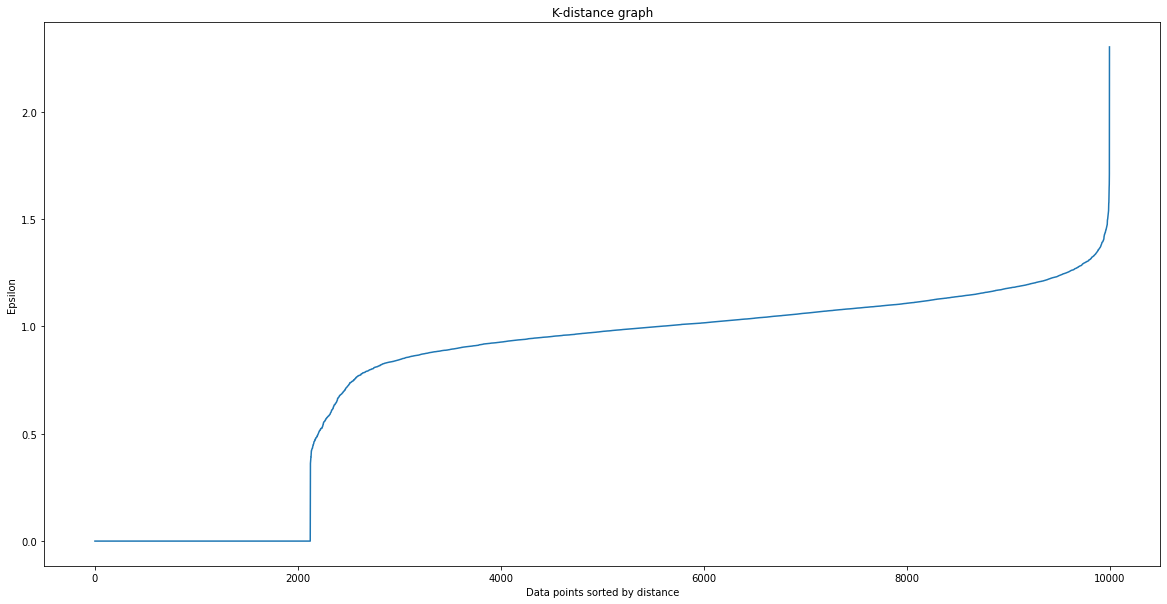

In [64]:
distances = np.sort(distances, axis=0)[:,1]
plt.figure(figsize = (20,10))
plt.plot(distances)
plt.title('K-distance graph')
plt.xlabel('Data points sorted by distance')
plt.ylabel('Epsilon')
plt.show()

In [109]:
# tokenizer(["a","a.","alexander", "alex", "arizona", "aria", "a.v", "aaron"])['input_ids']






# a.m.
# aa
# aires
# ai
# alexandria
# auburn
# aif
# alexandra

[[64],
 [64, 13],
 [1000, 87, 4066],
 [1000, 87],
 [283, 528, 4450],
 [10312],
 [64, 13, 85],
 [64, 8045]]

In [65]:
def find_duplicate_array_indices(arr_list):
    # Convert each array to a tuple for hashability
    arr_tuples = [tuple(arr.flatten()) for arr in arr_list]

    # Use defaultdict to store indices of each tuple
    index_dict = defaultdict(list)
    for idx, arr_tuple in enumerate(arr_tuples):
        index_dict[arr_tuple].append(idx)

    # Filter tuples with more than one occurrence
    duplicate_dict = {k: v for k, v in index_dict.items() if len(v) > 1}

    return duplicate_dict

In [66]:
def keys_with_more_than_x_values(input_dict, x):
    result_keys = [(key, values) for key, values in input_dict.items() if len(values) > x]
    return result_keys

In [67]:
# print(keys_with_more_than_x_values(find_duplicate_array_indices(result_list[0]),10))
for i in [5, 1571, 1780, 3272, 3865, 5616, 5675, 6192, 6492, 7116, 7420, 7528, 7565, 8446, 9078, 9173]:
    print(top_words[i])

a
a.
alexander
alex
arizona
aria
a.v
aaron
a.m.
aa
aires
ai
alexandria
auburn
aif
alexandra


In [7]:
differences = np.diff(distances)

slopes = differences / np.diff(np.arange(len(distances)))

# Find the index of the maximum slope
max_slope_index = np.argmax(slopes)

# The optimal epsilon is the distance at the point with the maximum slope
optimal_epsilon = distances[max_slope_index]

NameError: name 'distances' is not defined

In [63]:
print(optimal_epsilon)

0.6632238290182775


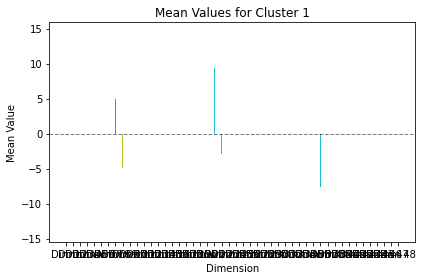

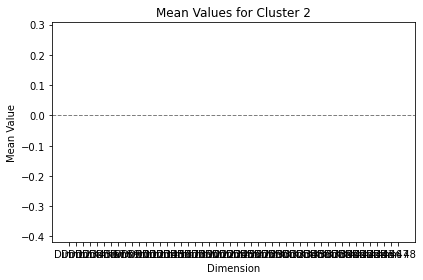

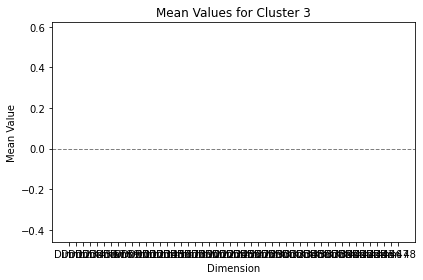

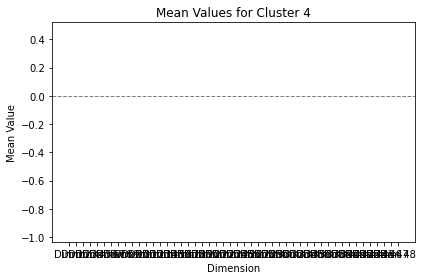

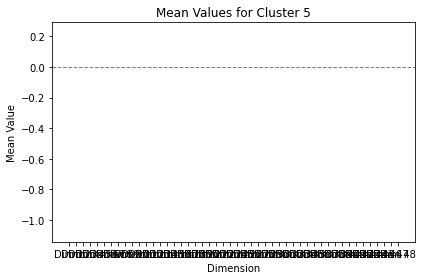

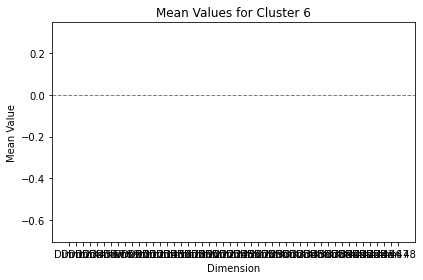

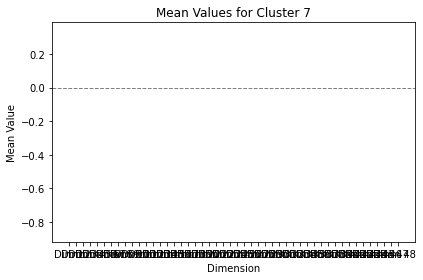

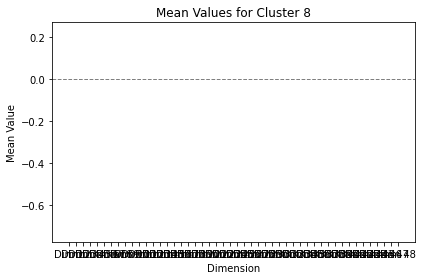

In [75]:
# Bar width for better visualization
num_bars = len(cluster_means[0])
bar_width = 0.8 / num_bars  # Adjusted bar width for better visualization

# Set up colors for each cluster
colors = plt.cm.tab10(np.arange(num_bars))

# Create individual subplots for each cluster
for i in range(num_clusters):
    fig, ax = plt.subplots()
    ax.bar(np.arange(num_bars), cluster_means[i], width=bar_width, color=colors)
    
    # Add labels and title
    ax.set_xlabel(f'Dimension')
    ax.set_ylabel(f'Mean Value')
    ax.set_title(f'Mean Values for Cluster {i+1}')
    ax.set_xticks(range(num_bars))
    ax.set_xticklabels([f'Dim {k+1}' for k in range(num_bars)])

    # Add a horizontal line at y=0 for better visualization
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--', alpha=0.5)

    # Show the plot
    plt.tight_layout()
    plt.show()
    

In [39]:
# #@markdown #**Function for finding indexes of a certain cluster**
# def ClusterIndicesNumpy(clustNum, labels_array): #numpy
#     return np.where(labels_array == clustNum)[0]

In [19]:
# #@markdown #**Function for retrieving words from indexes**
# def retrieve_words(cluster, words, kmeans):
#   idx = ClusterIndicesNumpy(cluster, kmeans.labels_)
#   results = []
#   for word in words:
#     if words.index(word) in idx:
#       results.append(word)
#   return results

In [20]:
# Foil_cluster = retrieve_words(7, top_words, kmeans)
# print(Foil_cluster)

In [21]:
# for i in range(8):
#   cluster = retrieve_words(i, top_words, kmeans)
#   print('Cluster',i)
#   print('------------------------------')
#   print(cluster[:10])
#   print('------------------------------')